# Imports

In [79]:
import pandas as pd
import numpy as np
import os
import inflection
import seaborn as sns
import lightgbm as lgb
import pickle
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec
import scipy.stats as ss
import xgboost as xgb
from boruta import BorutaPy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

### 0.1. Helper functions

In [2]:
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse }, index=[0] )

# Loading Data

In [3]:
train = pd.read_csv(r'C:\Users\PâmelaBotelhoMagalhã\OneDrive - Dataside\Documentos\Estudos\house_prices\house-prices-advanced-regression-techniques\train.csv')
test = pd.read_csv(r'C:\Users\PâmelaBotelhoMagalhã\OneDrive - Dataside\Documentos\Estudos\house_prices\house-prices-advanced-regression-techniques\test.csv')

# 1.0 Data Description

In [5]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [6]:
train.tail()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[5 rows x 81 columns]

In [7]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

1.1 Rename Columns

In [4]:
df1 = train.copy()

In [5]:
cols_old = ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice']

In [6]:
snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

# Rename
df1.columns = cols_new

In [11]:
# Verificando Rename método snakecase
df1.columns

Index(['id', 'ms_sub_class', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config',
       'land_slope', 'neighborhood', 'condition1', 'condition2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod_add', 'roof_style', 'roof_matl', 'exterior1st',
       'exterior2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmt_fin_type1', 'bsmt_fin_sf1', 'bsmt_fin_type2', 'bsmt_fin_sf2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abv_gr', 'kitchen_abv_gr', 'kitchen_qual',
       'tot_rms_abv_grd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_yr_blt', 'garage_finish'

1.2. Data Dimensions

In [12]:
df1.shape

(1460, 81)

1.3. Data types

In [13]:
df1.dtypes

id                  int64
ms_sub_class        int64
ms_zoning          object
lot_frontage      float64
lot_area            int64
                   ...   
mo_sold             int64
yr_sold             int64
sale_type          object
sale_condition     object
sale_price          int64
Length: 81, dtype: object

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1460 non-null   int64  
 1   ms_sub_class     1460 non-null   int64  
 2   ms_zoning        1460 non-null   object 
 3   lot_frontage     1201 non-null   float64
 4   lot_area         1460 non-null   int64  
 5   street           1460 non-null   object 
 6   alley            91 non-null     object 
 7   lot_shape        1460 non-null   object 
 8   land_contour     1460 non-null   object 
 9   utilities        1460 non-null   object 
 10  lot_config       1460 non-null   object 
 11  land_slope       1460 non-null   object 
 12  neighborhood     1460 non-null   object 
 13  condition1       1460 non-null   object 
 14  condition2       1460 non-null   object 
 15  bldg_type        1460 non-null   object 
 16  house_style      1460 non-null   object 
 17  overall_qual  

1.4 Check N/A's

In [15]:
df1.isnull().sum().sort_values(ascending=False).head(25)

pool_qc           1453
misc_feature      1406
alley             1369
fence             1179
mas_vnr_type       872
fireplace_qu       690
lot_frontage       259
garage_yr_blt       81
garage_cond         81
garage_type         81
garage_finish       81
garage_qual         81
bsmt_fin_type2      38
bsmt_exposure       38
bsmt_qual           37
bsmt_cond           37
bsmt_fin_type1      37
mas_vnr_area         8
electrical           1
id                   0
functional           0
fireplaces           0
kitchen_qual         0
kitchen_abv_gr       0
bedroom_abv_gr       0
dtype: int64

1.5. Fillout NA's

In [7]:
#Excluindo colunas
df1 = df1.drop(['pool_qc', 'misc_feature', 'alley', 'fence',], axis=1)

In [17]:
 #Verificando qtd valores
 df1['fireplace_qu'].value_counts()

fireplace_qu
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64

In [8]:
#Substituindo valores faltantes por um valor mais frequente
df1['fireplace_qu'].fillna('TA', inplace=True)

In [19]:
 #Verificando qtd valores
 df1['lot_frontage'].value_counts()

lot_frontage
60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: count, Length: 110, dtype: int64

In [20]:
print(df1['lot_frontage'].mean())

70.04995836802665


In [9]:
#Substituindo valores faltantes pela média
df1['lot_frontage'].fillna(df1['lot_frontage'].mean(), inplace=True)


In [22]:
 #Verificando valores
df1['garage_yr_blt'].unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [10]:
 #Substituindo valores faltantes pela média
 df1['garage_yr_blt'].fillna(df1['garage_yr_blt'].mean(), inplace= True)

In [24]:
 #Verificando qtd valores
 df1['garage_cond'].value_counts()

garage_cond
TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: count, dtype: int64

In [11]:
#Substituindo valores faltantes por um valor mais frequente
df1['garage_cond'].fillna('TA', inplace=True)

In [26]:
  #Verificando qtd valores
df1['garage_type'].value_counts()

garage_type
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64

In [12]:
#Substituindo valores faltantes por um valor mais frequente
df1['garage_type'].fillna('Attchd', inplace=True)

In [28]:
  #Verificando qtd valores
df1['garage_finish'].value_counts()

garage_finish
Unf    605
RFn    422
Fin    352
Name: count, dtype: int64

In [13]:
#Substituindo valores faltantes por um valor mais frequente
df1['garage_finish'].fillna('Unf', inplace=True)

In [30]:
#Verificando qtd valores
df1['garage_qual'].value_counts()

garage_qual
TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: count, dtype: int64

In [14]:
#Substituindo valores faltantes por um valor mais frequente
df1['garage_qual'].fillna('TA', inplace=True)

In [32]:
#Verificando qtd valores
df1['bsmt_fin_type2'].value_counts()

bsmt_fin_type2
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: count, dtype: int64

In [15]:
#Substituindo valores faltantes por um valor mais frequente
df1['bsmt_fin_type2'].fillna('Unf', inplace=True)

In [34]:
#Verificando qtd valores
df1['bsmt_exposure'].value_counts()

bsmt_exposure
No    953
Av    221
Gd    134
Mn    114
Name: count, dtype: int64

In [16]:
#Substituindo valores faltantes por um valor mais frequente
df1['bsmt_exposure'].fillna('No', inplace=True)

In [36]:
#Verificando qtd valores
df1['bsmt_qual'].value_counts()

bsmt_qual
TA    649
Gd    618
Ex    121
Fa     35
Name: count, dtype: int64

In [17]:
#Substituindo valores faltantes por um valor mais frequente
df1['bsmt_qual'].fillna('TA', inplace=True)

In [38]:
#Verificando qtd valores
df1['bsmt_cond'].value_counts()

bsmt_cond
TA    1311
Gd      65
Fa      45
Po       2
Name: count, dtype: int64

In [18]:
#Substituindo valores faltantes por um valor mais frequente
df1['bsmt_cond'].fillna('TA', inplace=True)

In [40]:
#Verificando qtd valores
df1['bsmt_fin_type1'].value_counts()

bsmt_fin_type1
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: count, dtype: int64

In [19]:
#Substituindo valores faltantes por um valor mais frequente
df1['bsmt_fin_type1'].fillna('Unf', inplace=True)

In [20]:
#Substituindo valores faltantes pela média
df1['mas_vnr_area'].fillna(df1['mas_vnr_area'].mean(), inplace= True)

In [43]:
#Verificando qtd valores
df1['mas_vnr_type'].value_counts()

mas_vnr_type
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

In [21]:
#Substituindo valores faltantes por um valor mais frequente
df1['mas_vnr_type'].fillna('None', inplace=True)

In [45]:
#Verificando qtd valores
df1['electrical'].value_counts()

electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64

In [22]:
#Substituindo valores faltantes por um valor mais frequente
df1['electrical'].fillna('SBrkr', inplace=True)

In [47]:
#Verificando se ainda há N/As
df1.isnull().sum().sort_values(ascending=False).head(25)

id                 0
half_bath          0
fireplace_qu       0
fireplaces         0
functional         0
tot_rms_abv_grd    0
kitchen_qual       0
kitchen_abv_gr     0
bedroom_abv_gr     0
full_bath          0
heating_qc         0
bsmt_half_bath     0
bsmt_full_bath     0
gr_liv_area        0
low_qual_fin_sf    0
2nd_flr_sf         0
1st_flr_sf         0
electrical         0
garage_type        0
garage_yr_blt      0
garage_finish      0
garage_cars        0
sale_condition     0
sale_type          0
yr_sold            0
dtype: int64

1.6. Change Types

In [48]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1460 non-null   int64  
 1   ms_sub_class     1460 non-null   int64  
 2   ms_zoning        1460 non-null   object 
 3   lot_frontage     1460 non-null   float64
 4   lot_area         1460 non-null   int64  
 5   street           1460 non-null   object 
 6   lot_shape        1460 non-null   object 
 7   land_contour     1460 non-null   object 
 8   utilities        1460 non-null   object 
 9   lot_config       1460 non-null   object 
 10  land_slope       1460 non-null   object 
 11  neighborhood     1460 non-null   object 
 12  condition1       1460 non-null   object 
 13  condition2       1460 non-null   object 
 14  bldg_type        1460 non-null   object 
 15  house_style      1460 non-null   object 
 16  overall_qual     1460 non-null   int64  
 17  overall_cond  

In [23]:
# Convertendo de float para int
df1['garage_yr_blt'] = df1['garage_yr_blt'].astype(int)


1.7. Descriptive Statistical

In [24]:
num_attributes = df1.select_dtypes (include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes (exclude = ['int64', 'float64','int32'])

In [51]:
#Verificando
num_attributes.sample(2)

id  ms_sub_class  lot_frontage  lot_area  overall_qual  overall_cond  \
61  62            75          60.0      7200             5             7   
13  14            20          91.0     10652             7             5   

    year_built  year_remod_add  mas_vnr_area  bsmt_fin_sf1  ...  wood_deck_sf  \
61        1920            1996           0.0             0  ...             0   
13        2006            2007         306.0             0  ...           160   

    open_porch_sf  enclosed_porch  3_ssn_porch  screen_porch  pool_area  \
61              0             144            0             0          0   
13             33               0            0             0          0   

    misc_val  mo_sold  yr_sold  sale_price  
61         0        3     2007      101000  
13         0        8     2007      279500  

[2 rows x 37 columns]

In [52]:
#Verificando
cat_attributes.sample(2)

ms_zoning street lot_shape land_contour utilities lot_config land_slope  \
539        RL   Pave       Reg          Lvl    AllPub     Inside        Gtl   
974        RL   Pave       IR1          Lvl    AllPub     Corner        Gtl   

    neighborhood condition1 condition2  ... kitchen_qual functional  \
539      CollgCr       Norm       Norm  ...           Gd        Typ   
974      BrkSide       RRAn      Feedr  ...           Gd        Typ   

    fireplace_qu garage_type garage_finish garage_qual garage_cond  \
539           TA      Attchd           RFn          TA          TA   
974           TA      Detchd           Unf          TA          TA   

    paved_drive sale_type sale_condition  
539           Y        WD         Normal  
974           Y        WD         Normal  

[2 rows x 39 columns]

1.7.1 Numerical Attributes

In [25]:
#Central Tendency - Mean and Median
ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew and kurtosis
d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(min)).T
d3 = pd.DataFrame (num_attributes.apply(max)).T
d4 = pd.DataFrame (num_attributes.apply (lambda x: x.max() - x.min())).T
d5 = pd.DataFrame (num_attributes.apply (lambda x: x.skew () )).T
d6 = pd.DataFrame (num_attributes.apply (lambda x: x.kurtosis () )).T

#Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

attributes      min       max     range           mean  \
0                id      1.0    1460.0    1459.0     730.500000   
1      ms_sub_class     20.0     190.0     170.0      56.897260   
2      lot_frontage     21.0     313.0     292.0      70.049958   
3          lot_area   1300.0  215245.0  213945.0   10516.828082   
4      overall_qual      1.0      10.0       9.0       6.099315   
5      overall_cond      1.0       9.0       8.0       5.575342   
6        year_built   1872.0    2010.0     138.0    1971.267808   
7    year_remod_add   1950.0    2010.0      60.0    1984.865753   
8      mas_vnr_area      0.0    1600.0    1600.0     103.685262   
9      bsmt_fin_sf1      0.0    5644.0    5644.0     443.639726   
10     bsmt_fin_sf2      0.0    1474.0    1474.0      46.549315   
11      bsmt_unf_sf      0.0    2336.0    2336.0     567.240411   
12    total_bsmt_sf      0.0    6110.0    6110.0    1057.429452   
13       1st_flr_sf    334.0    4692.0    4358.0    1162.626712   
14       2nd_flr_sf      0.0    2065.0    2065.0     346.992466   
15  low_qual_fin_sf      0.0     572.0     572.0       5.844521   
16      gr_liv_area    334.0    5642.0    5308.0    1515.463699   
17   bsmt_full_bath      0.0       3.0       3.0       0.425342   
18   bsmt_half_bath      0.0       2.0       2.0       0.057534   
19        full_bath      0.0       3.0       3.0       1.565068   
20        half_bath      0.0       2.0       2.0       0.382877   
21   bedroom_abv_gr      0.0       8.0       8.0       2.866438   
22   kitchen_abv_gr      0.0       3.0       3.0       1.046575   
23  tot_rms_abv_grd      2.0      14.0      12.0       6.517808   
24       fireplaces      0.0       3.0       3.0       0.613014   
25      garage_cars      0.0       4.0       4.0       1.767123   
26      garage_area      0.0    1418.0    1418.0     472.980137   
27     wood_deck_sf      0.0     857.0     857.0      94.244521   
28    open_porch_sf      0.0     547.0     547.0      46.660274   
29   enclosed_porch      0.0     552.0     552.0      21.954110   
30      3_ssn_porch      0.0     508.0     508.0       3.409589   
31     screen_porch      0.0     480.0     480.0      15.060959   
32        pool_area      0.0     738.0     738.0       2.758904   
33         misc_val      0.0   15500.0   15500.0      43.489041   
34          mo_sold      1.0      12.0      11.0       6.321918   
35          yr_sold   2006.0    2010.0       4.0    2007.815753   
36       sale_price  34900.0  755000.0  720100.0  180921.195890   

           median           std       skew    kurtosis  
0      730.500000    421.465598   0.000000   -1.200000  
1       50.000000     42.286082   1.407657    1.580188  
2       70.049958     22.016479   2.384950   21.848165  
3     9478.500000   9977.846105  12.207688  203.243271  
4        6.000000      1.382523   0.216944    0.096293  
5        5.000000      1.112418   0.693067    1.106413  
6     1973.000000     30.192559  -0.613461   -0.439552  
7     1994.000000     20.638335  -0.503562   -1.272245  
8        0.000000    180.507263   2.676412   10.154316  
9      383.500000    455.941866   1.685503   11.118236  
10       0.000000    161.264017   4.255261   20.113338  
11     477.500000    441.715605   0.920268    0.474994  
12     991.500000    438.555057   1.524255   13.250483  
13    1087.000000    386.455322   1.376757    5.745841  
14       0.000000    436.378914   0.813030   -0.553464  
15       0.000000     48.606427   9.011341   83.234817  
16    1464.000000    525.300394   1.366560    4.895121  
17       0.000000      0.518733   0.596067   -0.839098  
18       0.000000      0.238671   4.103403   16.396642  
19       2.000000      0.550727   0.036562   -0.857043  
20       0.000000      0.502713   0.675897   -1.076927  
21       3.000000      0.815499   0.211790    2.230875  
22       1.000000      0.220263   4.488397   21.532404  
23       6.000000      1.624837   0.676341    0.880762  
24       1.000000      0.644446   0.6

<Axes: xlabel='sale_price', ylabel='Density'>

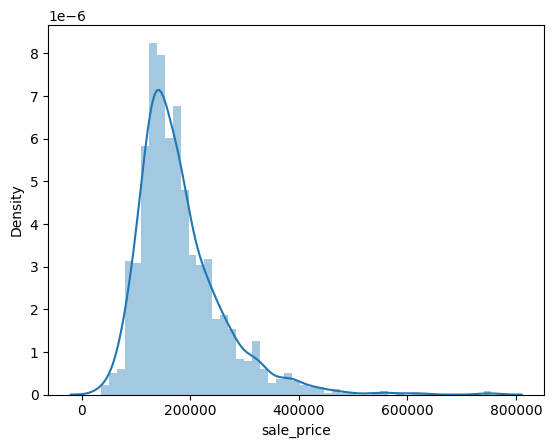

In [54]:
sns.distplot (df1['sale_price'])

<Axes: xlabel='lot_area', ylabel='Density'>

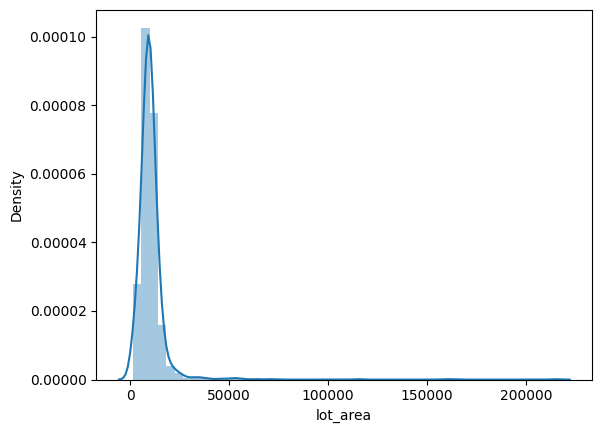

In [55]:
sns.distplot (df1['lot_area'])

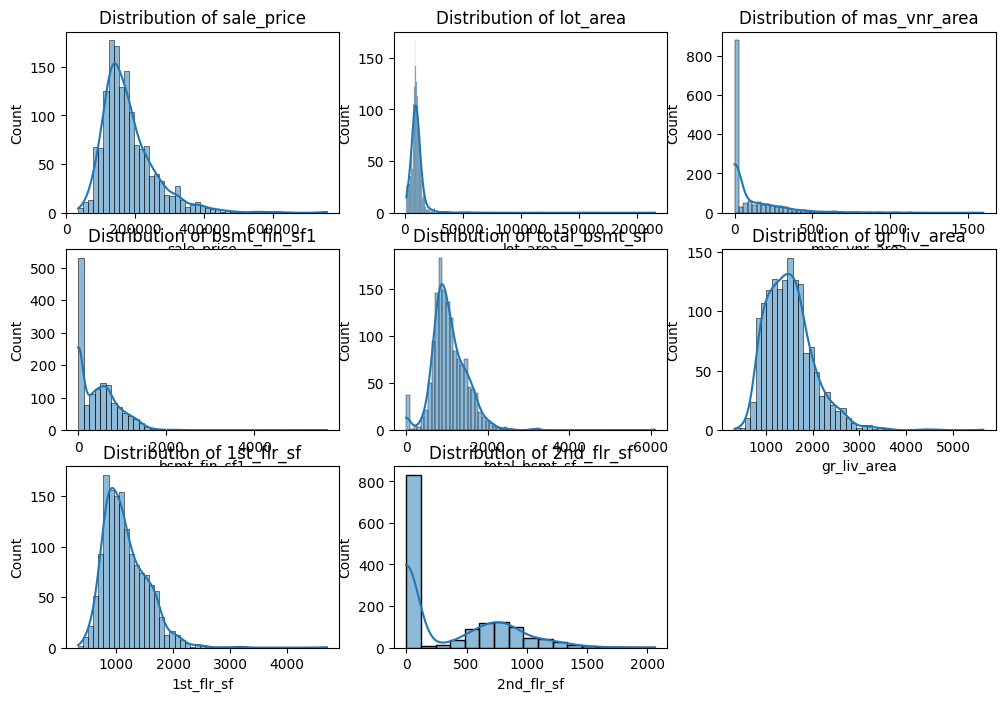

In [56]:
# Lista de variáveis numéricas a serem plotadas
variables_to_plot = ['sale_price', 'lot_area', 'mas_vnr_area', 'bsmt_fin_sf1', 'total_bsmt_sf', 'gr_liv_area','1st_flr_sf','2nd_flr_sf']

# Configurar subplots
plt.figure(figsize=(12, 8))
for i, variable in enumerate(variables_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df1[variable], kde=True)
    plt.title(f'Distribution of {variable}')

1.7.2 Categorical Attributes

In [57]:
cat_attributes.apply (lambda x: x.unique().shape[0])

ms_zoning          5
street             2
lot_shape          4
land_contour       4
utilities          2
lot_config         5
land_slope         3
neighborhood      25
condition1         9
condition2         8
bldg_type          5
house_style        8
roof_style         6
roof_matl          8
exterior1st       15
exterior2nd       16
mas_vnr_type       4
exter_qual         4
exter_cond         5
foundation         6
bsmt_qual          4
bsmt_cond          4
bsmt_exposure      4
bsmt_fin_type1     6
bsmt_fin_type2     6
heating            6
heating_qc         5
central_air        2
electrical         5
kitchen_qual       4
functional         7
fireplace_qu       5
garage_type        6
garage_finish      3
garage_qual        5
garage_cond        5
paved_drive        3
sale_type          9
sale_condition     6
dtype: int64

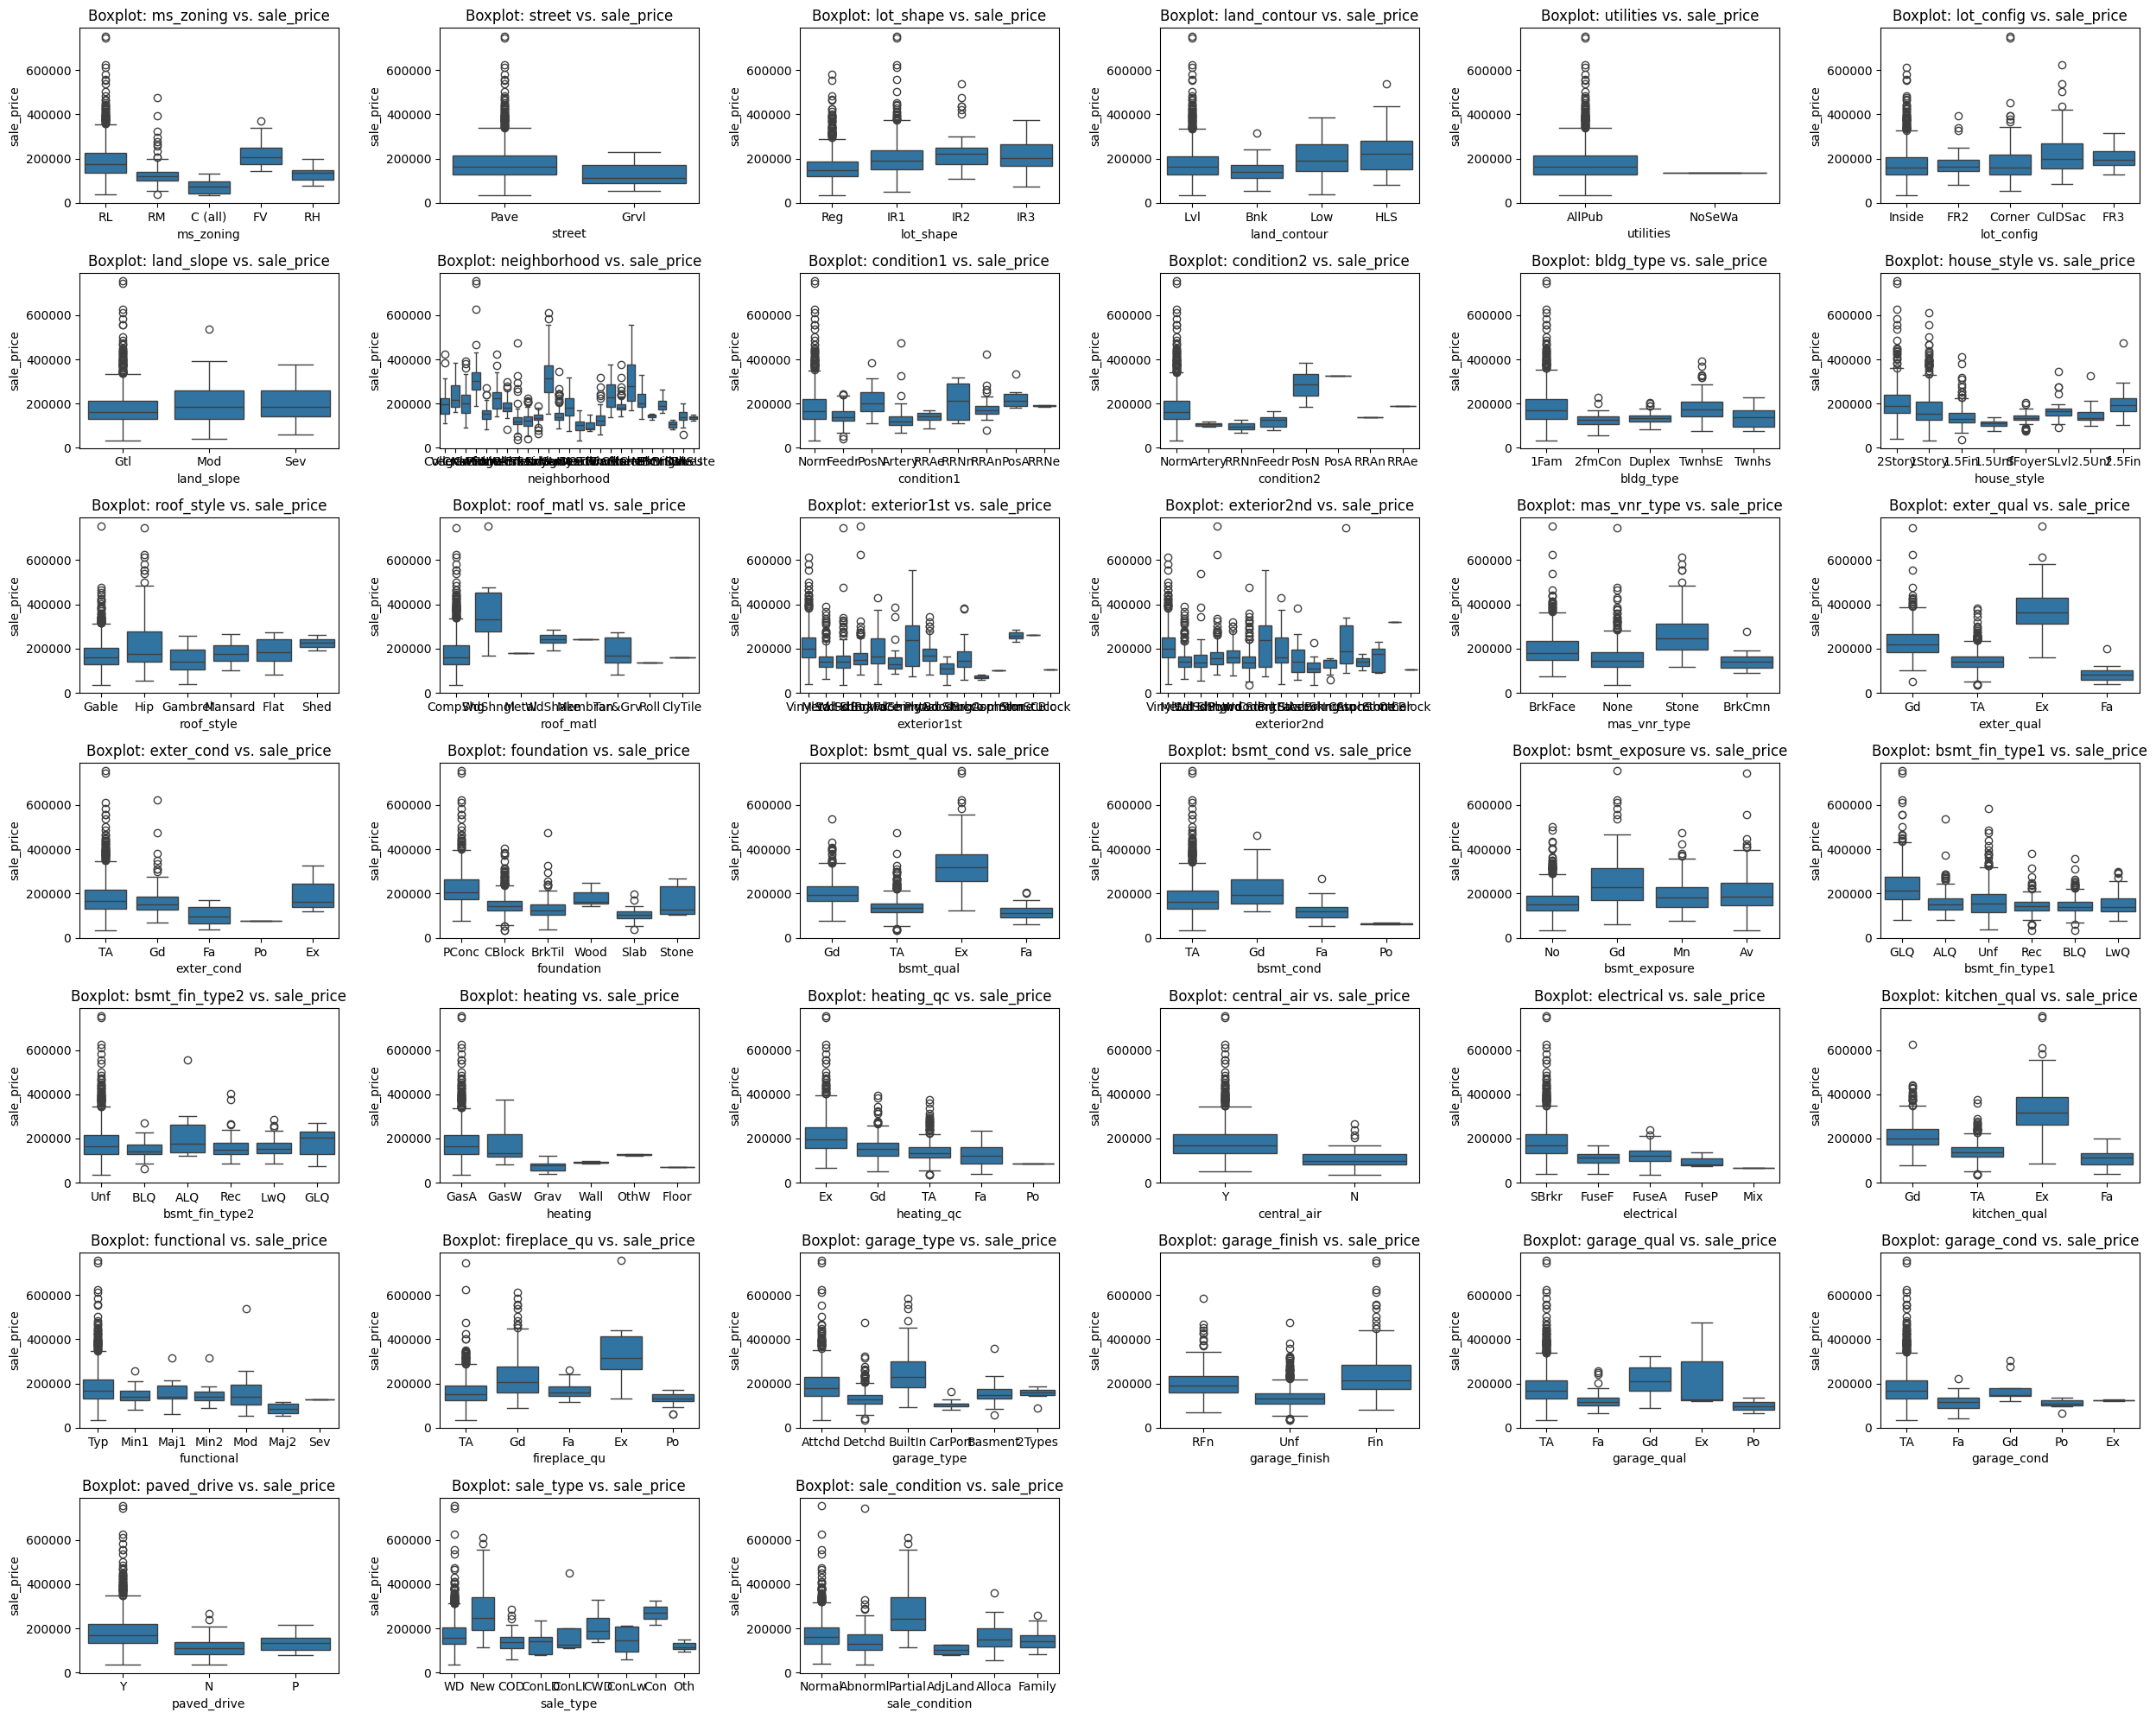

In [58]:
# Boxplot
plt.figure(figsize=(25, 20))
for i, variable in enumerate(cat_attributes.columns, 1):
    plt.subplot(7, 6, i)
    sns.boxplot(x=variable, y='sale_price', data=df1)
    plt.title(f'Boxplot: {variable} vs. sale_price')

plt.tight_layout()
plt.show()

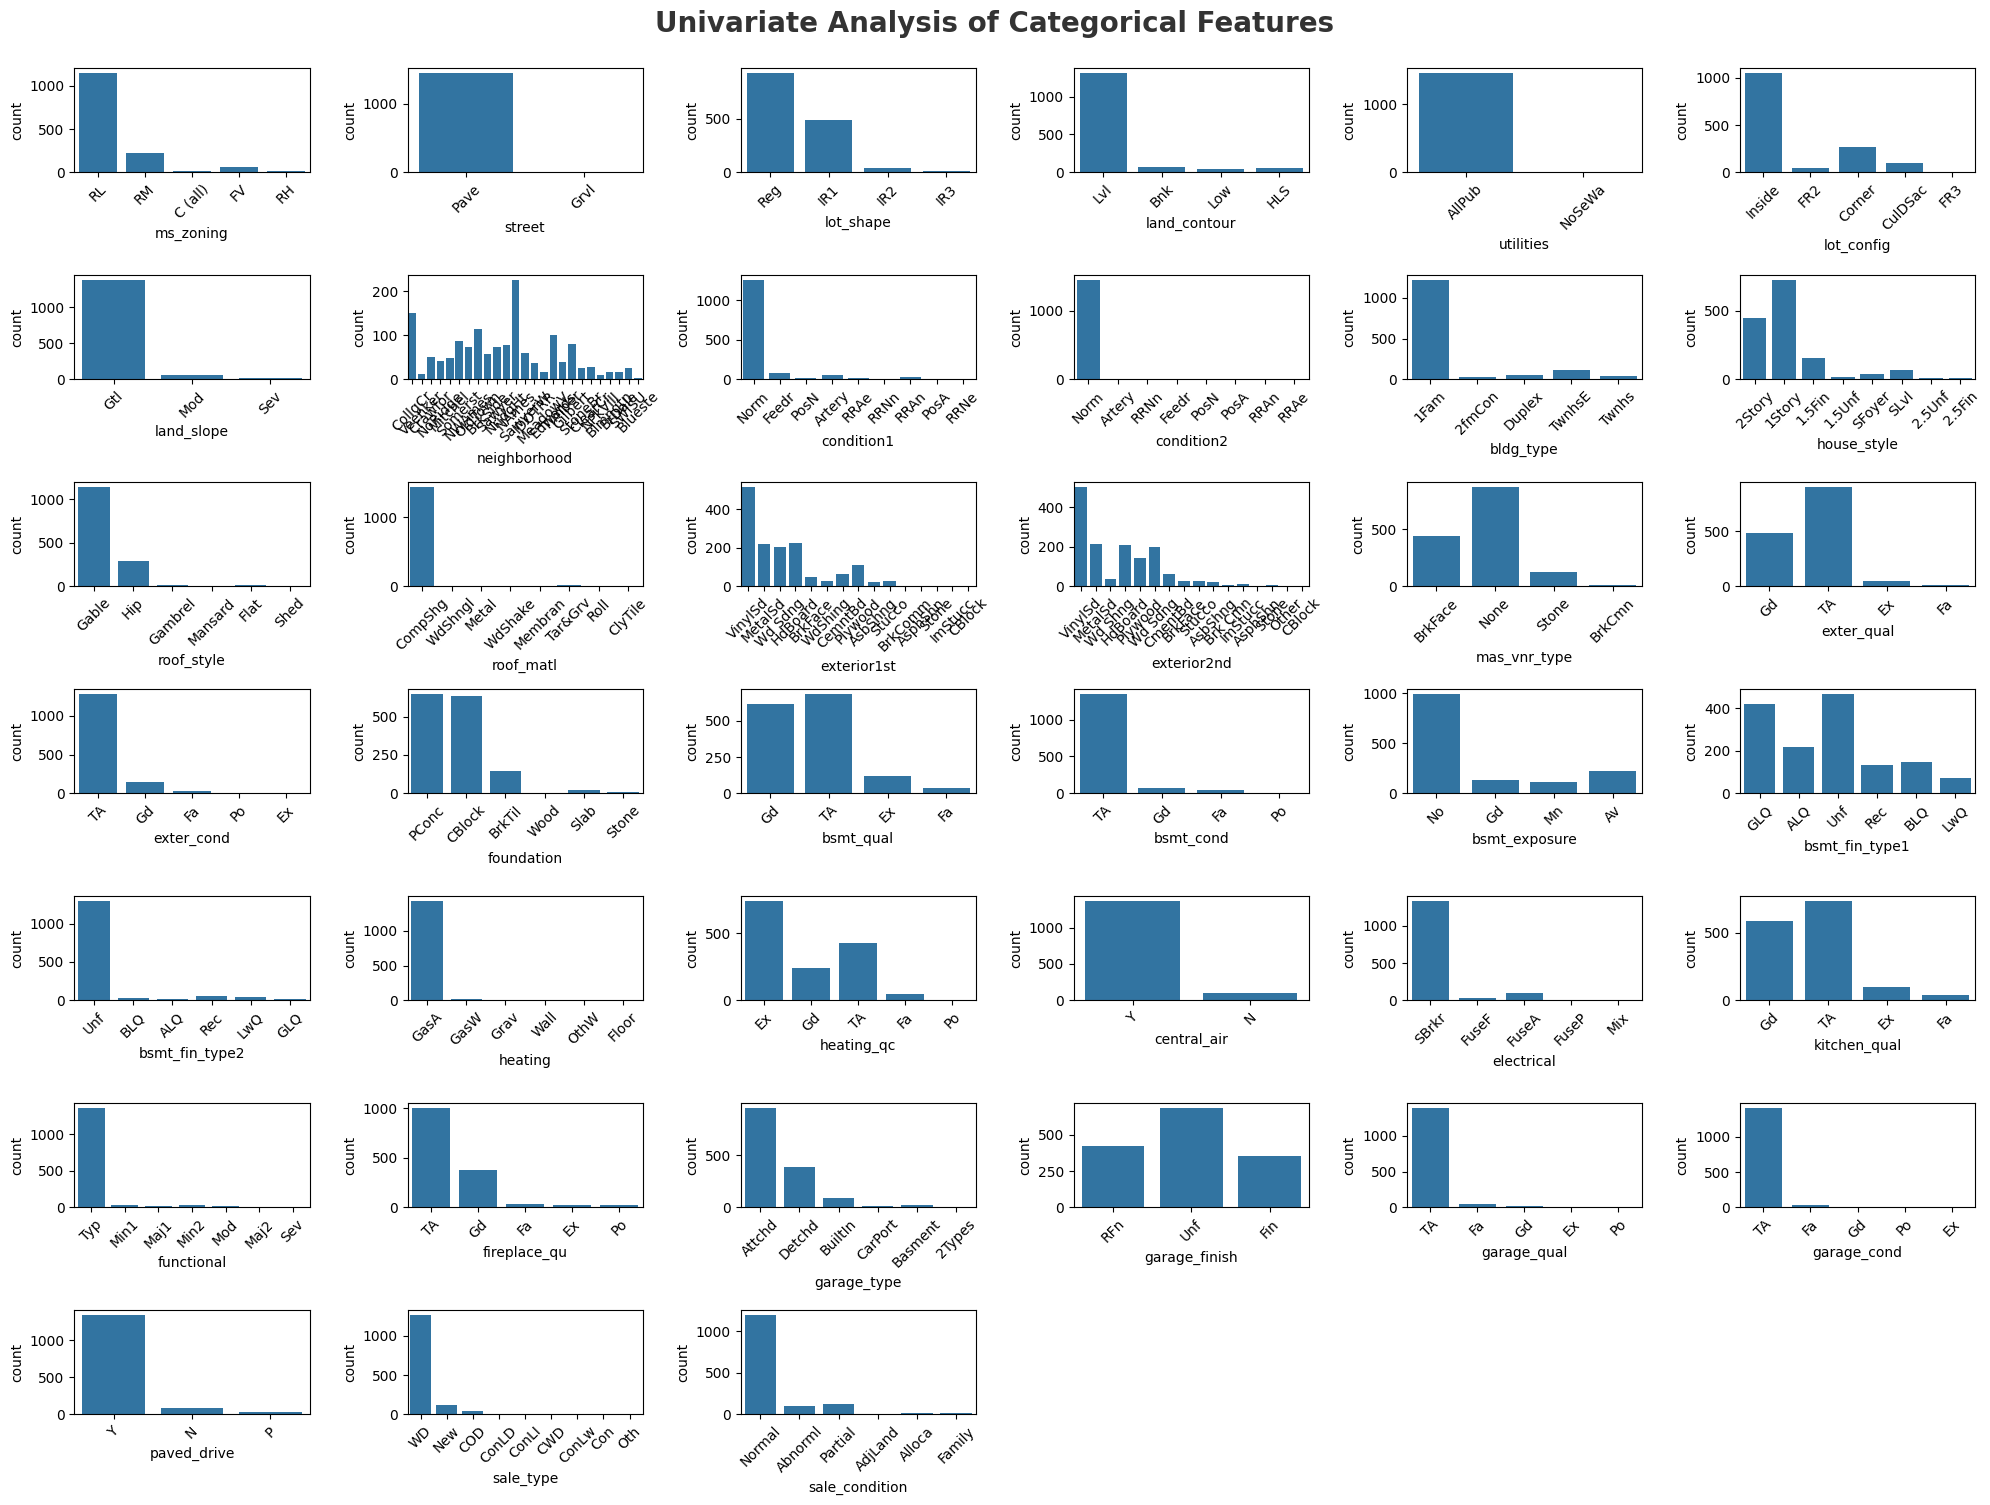

In [59]:
# Barplot
plt.figure(figsize=(20, 15))
plt.suptitle("Univariate Analysis of Categorical Features", fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i, col in enumerate(cat_attributes):
    plt.subplot(7, 6, i + 1)
    sns.countplot(x=df1[col])
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()




#2.0. FEATURE ENGENEERING

In [26]:
df2 = df1.copy ()

2.1 Mapa mental de hipóteses

In [61]:
mapa_mental = list(uploaded.keys())[0]

NameError: name 'uploaded' is not defined

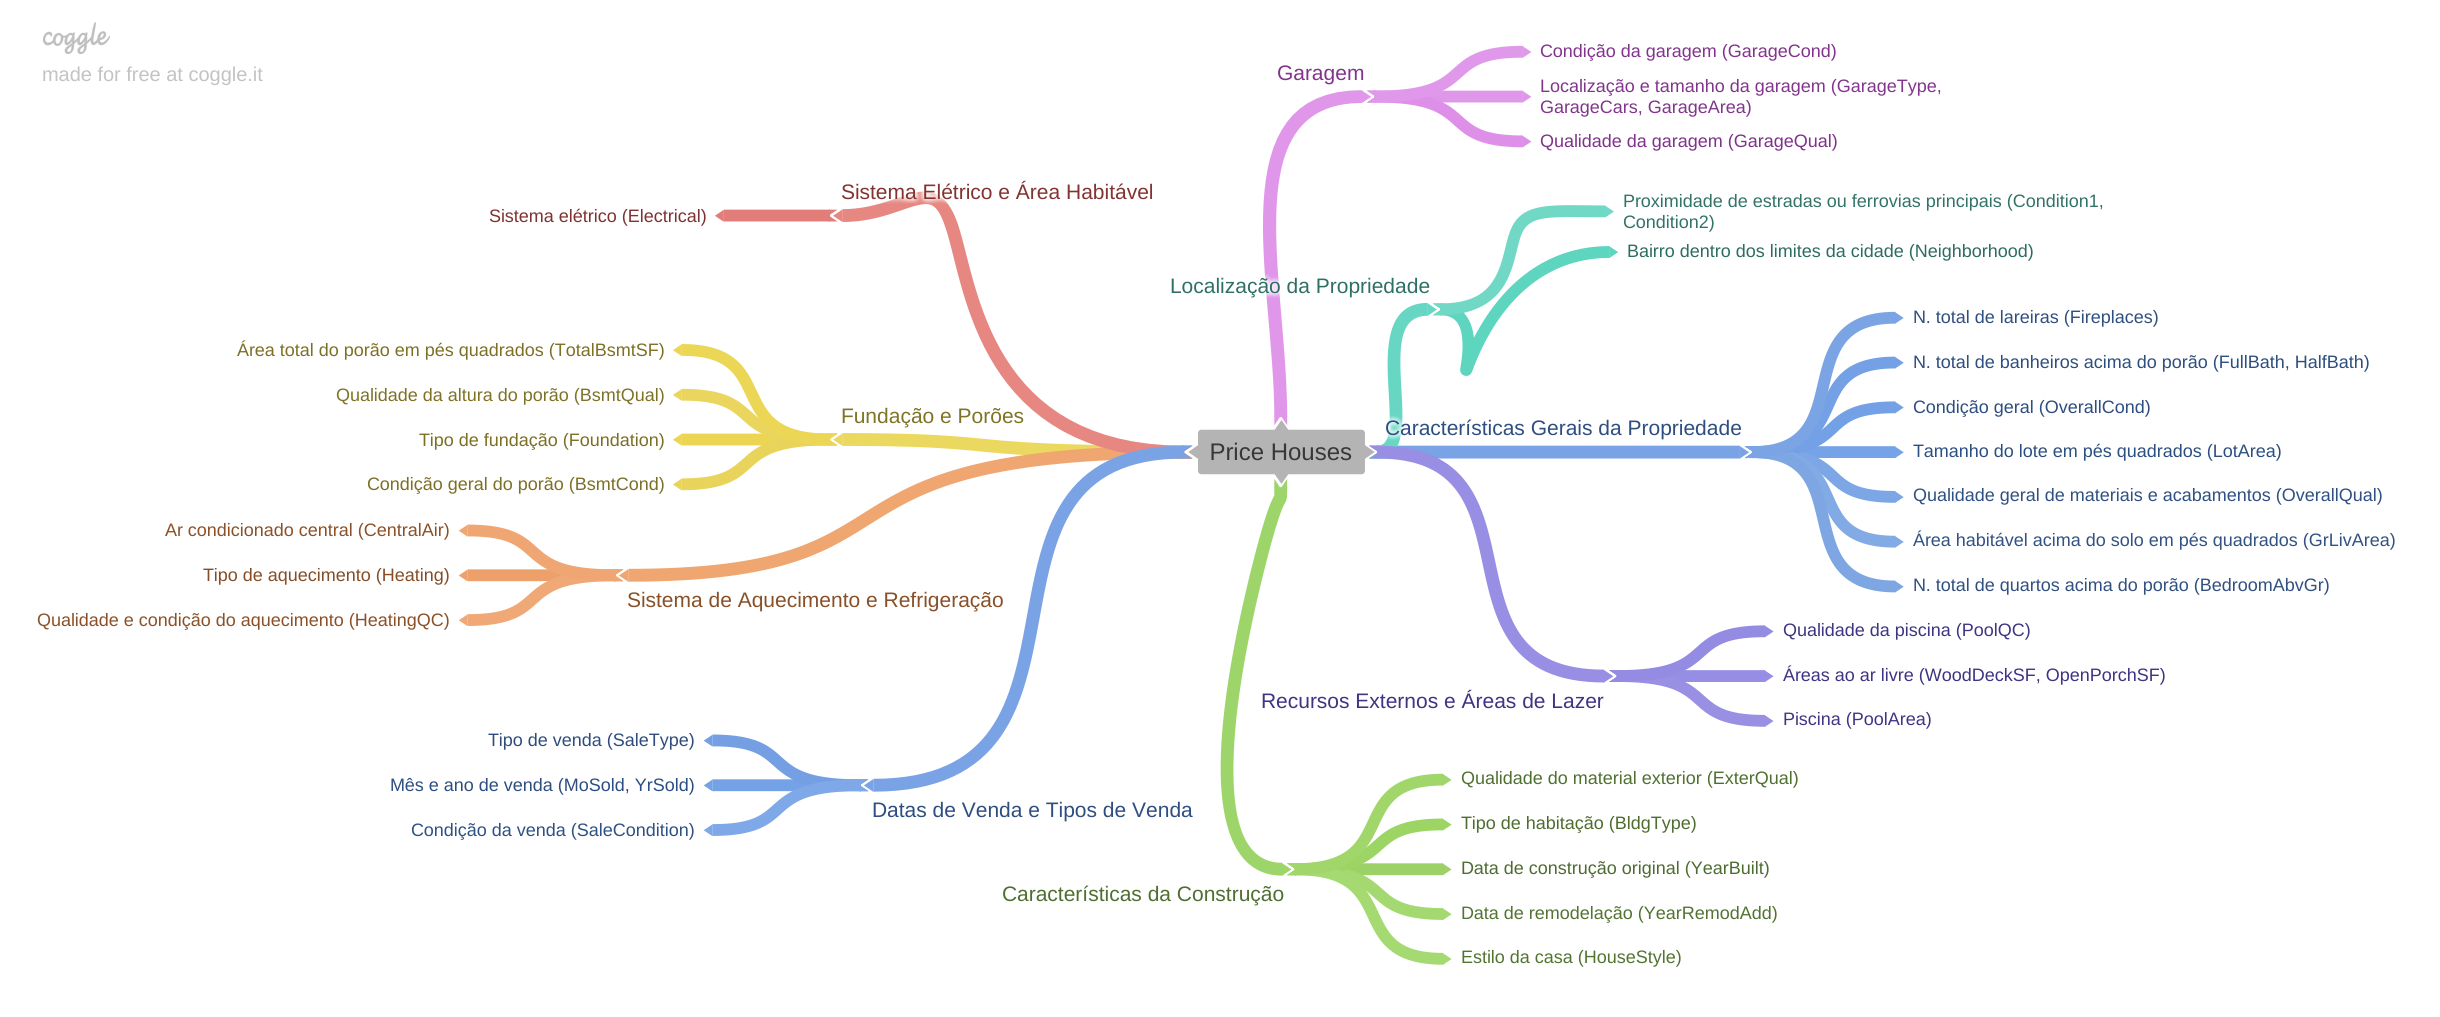

In [ ]:
Image(filename=mapa_mental)

### 2.2 Criação das hipóteses

2.2.1 Hipóteses Datas de Venda e Tipos de venda

##### 1.Vendas feitas na mesma família pode reduzir o preço.
##### 2. O momento da venda pode afetar os preços, com possíveis variações sazonais
##### 3. Vendas com financiamento convencional (WD) podem ter preços diferentes em comparação com vendas à vista (CWD) ou contratos especiais (Con, ConLw, ConLI, ConLD).
##### 4. Propriedades vendidas como "New" (novas construções) podem ter preços mais altos devido ao valor percebido de uma casa recém-construída.
##### 5. Vendas em dinheiro podem ter uma dinâmica diferente em comparação com vendas financiadas.
##### 6. Vendas com contratos e financiamentos diferentes podem ter variações nos preços.



 2.2.2 Hipóteses Características Gerais da Propriedade

##### 1. Propriedades com lotes maiores tendem a ter preços mais altos devido ao espaço adicional e potencial para expansão.
##### 2. A qualidade geral dos materiais e acabamentos tem uma correlação positiva com o preço de venda. Propriedades com classificação de qualidade mais alta podem ter preços mais elevados.
##### 3. A condição geral da propriedade afeta o preço. Propriedades em boas condições tendem a ter valores mais altos
##### 4.  espaço habitável acima do solo está diretamente relacionado ao preço. Propriedades com mais espaço geralmente têm preços mais elevados.
##### 5. O número total de banheiros influencia o preço.
##### 6. O número de quartos afeta o preço.
##### 7.  A presença de lareiras pode influenciar positivamente o preço.






2.2.3 Hipóteses Recursos Externos e Áreas de Lazer

##### 1. A qualidade da piscina, e se há ou não piscina pode influenciar no preço de venda (PoolQC).

2.2.4 Hipóteses Sistema de aquecimento e refrigeração.

##### 1. Sistemas de aquecimento e ar condicionado eficientes e de alta qualidade podem aumentar o preço do imóvel.


2.2.5 Hipóteses Características Construção

##### 1. Data de construção original (YearBuilt). Quanto mais antigo mais barato o imóvel.


### 2.3 Lista Final das hipóteses (Hipóteses que temos dados para comprovar)

##### 1.O momento da venda pode afetar os preços, com possíveis variações sazonais.
##### 2.0 Vendas com financiamento convencional (WD) podem ter preços diferentes em comparação com vendas à vista (CWD) ou contratos especiais (Con, ConLw, ConLI, ConLD).
##### 3.0 Propriedades vendidas como "New" (novas construções) podem ter preços mais altos devido ao valor percebido de uma casa recém-construída.
##### 4.0  Propriedades com lotes maiores tendem a ter preços mais altos devido ao espaço adicional e potencial para expansão.
##### 5.0 A qualidade geral dos materiais e acabamentos tem uma correlação positiva com o preço de venda. Propriedades com classificação de qualidade mais alta podem ter preços mais elevados.
##### 6.0 O número total de banheiros influencia o preço.
##### 7.0 O número de quartos afeta o preço.
##### 8.0  A presença de lareiras pode influenciar o aumento no preço.
##### 9.0 Sistemas de aquecimento e ar condicionado eficientes e de alta qualidade podem aumentar o preço do imóvel.
##### 10.0 Data de construção original (YearBuilt). Quanto mais antigo mais barato o imóvel.




### 2.4 Feature Engineering

In [29]:
# Idade da propriedade no momento da venda.
df2['age'] = df2['yr_sold'] - df2['year_built']

#Há lareira?
df2 ['fireplaces_'] = df2 ['fireplaces'].apply (lambda x: 1 if x>= 1 else 0)

#Há piscina?
df2 ['pool'] = df2 ['pool_area'].apply (lambda x: 1 if x>= 1 else 0)

#Há segundo andar?
df2['2nd_flr'] = df2['2nd_flr_sf'].apply (lambda x: 1 if x> 1 else 0)

#Há revestimento em alvenaria?
df2['veener'] = df2['mas_vnr_area'].apply (lambda x: 1 if x> 1 else 0)

# Total_bathrooms
df2['total_bathrooms'] = df2['full_bath'] + df2['half_bath'] + df2['bsmt_full_bath'] + df2['bsmt_half_bath']
print(df2['total_bathrooms'].value_counts())




total_bathrooms
2    572
3    477
1    228
4    172
5      8
6      3
Name: count, dtype: int64


In [ ]:
#Verificando
df2.head().T

0     1      2     3      4
id                  1     2      3     4      5
ms_sub_class       60    20     60    70     60
ms_zoning          RL    RL     RL    RL     RL
lot_frontage     65.0  80.0   68.0  60.0   84.0
lot_area         8450  9600  11250  9550  14260
...               ...   ...    ...   ...    ...
fireplaces_         0     1      1     1      1
pool                0     0      0     0      0
2nd_flr             1     0      1     1      1
veener              1     0      1     0      1
total_bathrooms     4     3      4     2      4

[83 rows x 5 columns]

# 3.0. Feature Selection

In [30]:
df3 = df2.copy()

In [ ]:
df3.head()

id  ms_sub_class ms_zoning  lot_frontage  lot_area street lot_shape  \
0   1            60        RL          65.0      8450   Pave       Reg   
1   2            20        RL          80.0      9600   Pave       Reg   
2   3            60        RL          68.0     11250   Pave       IR1   
3   4            70        RL          60.0      9550   Pave       IR1   
4   5            60        RL          84.0     14260   Pave       IR1   

  land_contour utilities lot_config  ... yr_sold sale_type sale_condition  \
0          Lvl    AllPub     Inside  ...    2008        WD         Normal   
1          Lvl    AllPub        FR2  ...    2007        WD         Normal   
2          Lvl    AllPub     Inside  ...    2008        WD         Normal   
3          Lvl    AllPub     Corner  ...    2006        WD        Abnorml   
4          Lvl    AllPub        FR2  ...    2008        WD         Normal   

  sale_price age fireplaces_  pool  2nd_flr  veener  total_bathrooms  
0     208500   5           0     0        1       1                4  
1     181500  31           1     0        0       0                3  
2     223500   7           1     0        1       1                4  
3     140000  91           1     0        1       0                2  
4     250000   8           1     0        1       1                4  

[5 rows x 83 columns]

## 3.1 Filtragem das linhas

## 3.2 Seleção das colunas

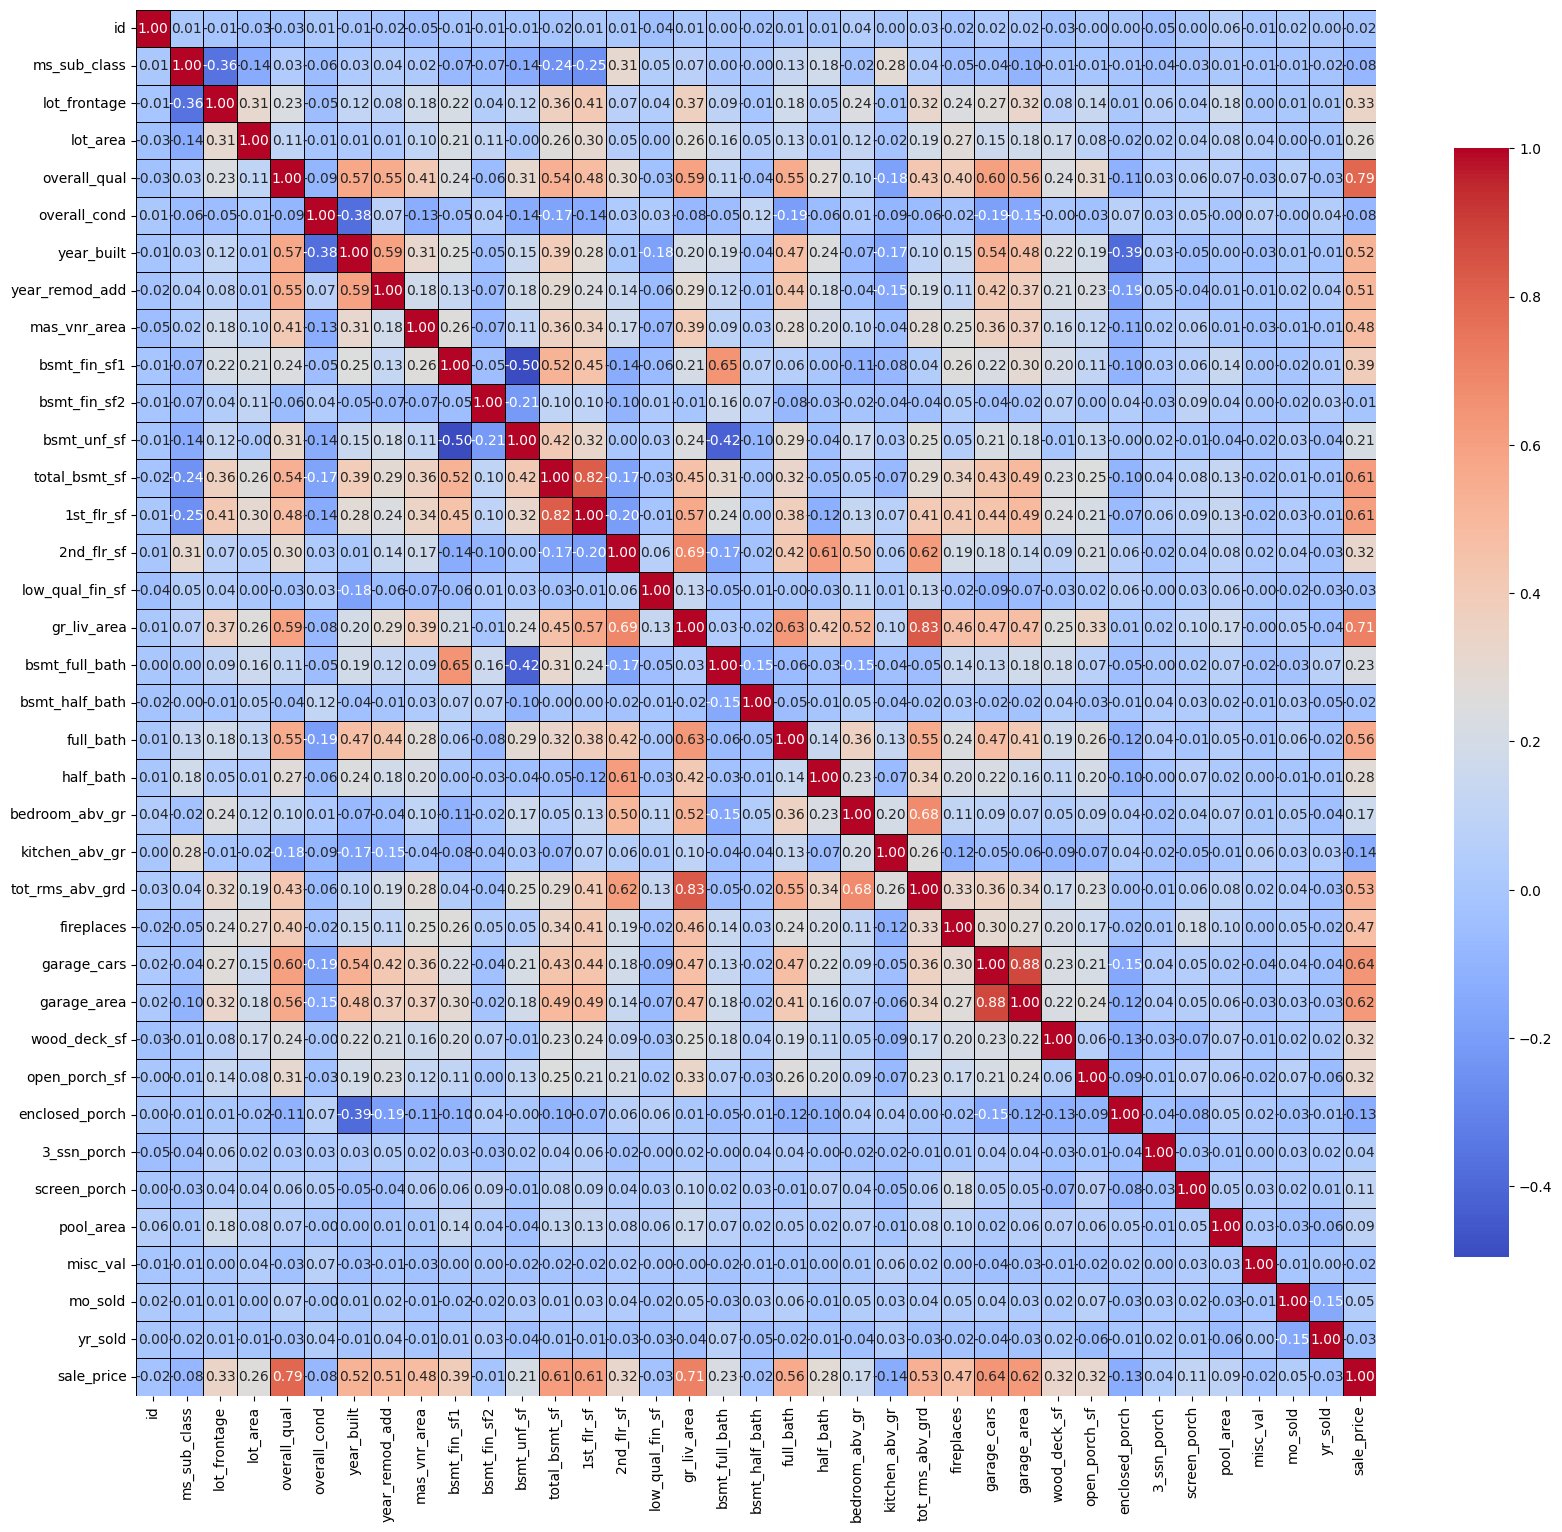

In [ ]:
plt.figure(figsize=(20, 18))
#Matriz de Correlação
correlation = num_attributes.corr(method='pearson')

# Heatmap com rotação nos rótulos
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, linecolor='black', xticklabels=correlation.columns, yticklabels=correlation.columns, cbar_kws={"shrink": 0.8})

# Espaçamento entre os rótulos
plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.show()

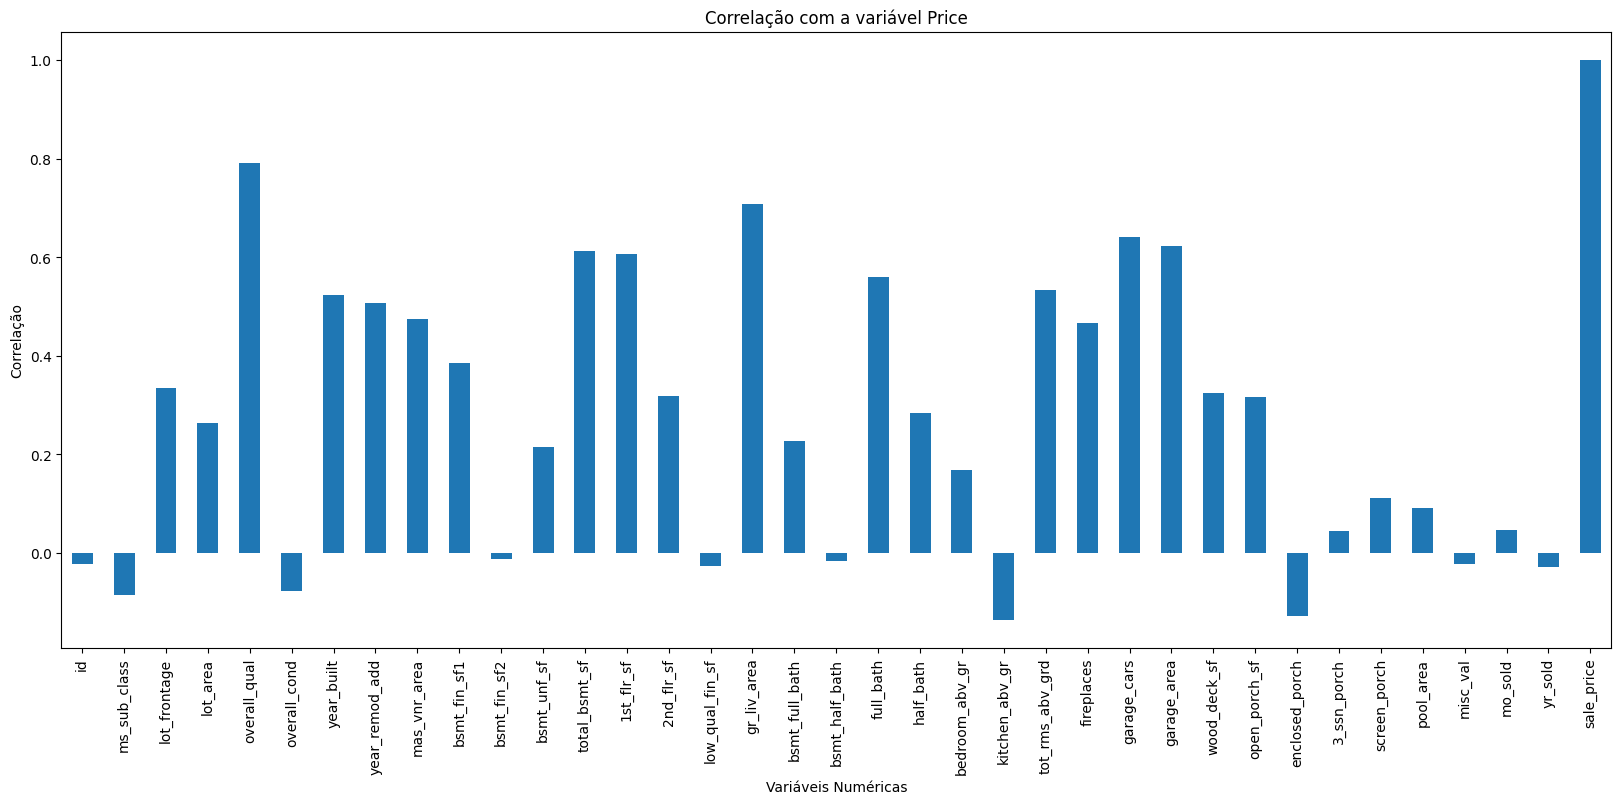

In [ ]:
# Matriz de correlação entre as variáveis numéricas e a variável alvo (price)
correlation_with_price = num_attributes.corrwith(df3['sale_price'])

plt.figure(figsize=(20, 8))
correlation_with_price.plot(kind='bar')
plt.title('Correlação com a variável Price')
plt.xlabel('Variáveis Numéricas')
plt.ylabel('Correlação')
plt.show()

In [ ]:
# Colunas numéricas irrelevantes
#irrelevant_cols = ['id', 'mo_sold', 'yr_sold','3_ssn_porch','bsmt_half_bath','low_qual_fin_sf','bsmt_fin_sf2','ms_sub_class','overall_cond','kitchen_abv_gr','enclosed_porch','screen_porch','misc_val','bsmt_unf_sf','bedroom_abv_gr','pool_area','bsmt_full_bath','lot_frontage','2nd_flr_sf','wood_deck_sf', 'open_porch_sf']
#num_attributes = num_attributes.drop(columns=irrelevant_cols)

In [31]:
#Adicionando colunas criadas
feature_engineered_cols = ['age', 'pool', '2nd_flr', 'total_bathrooms','fireplaces_','veener']

#for col in feature_engineered_cols:
    #num_attributes[col] = feature_engineered_df[col]

In [65]:
print(num_attributes.columns)

Index(['id', 'ms_sub_class', 'lot_frontage', 'lot_area', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod_add', 'mas_vnr_area',
       'bsmt_fin_sf1', 'bsmt_fin_sf2', 'bsmt_unf_sf', 'total_bsmt_sf',
       '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area',
       'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath',
       'bedroom_abv_gr', 'kitchen_abv_gr', 'tot_rms_abv_grd', 'fireplaces',
       'garage_cars', 'garage_area', 'wood_deck_sf', 'open_porch_sf',
       'enclosed_porch', '3_ssn_porch', 'screen_porch', 'pool_area',
       'misc_val', 'mo_sold', 'yr_sold', 'sale_price'],
      dtype='object')


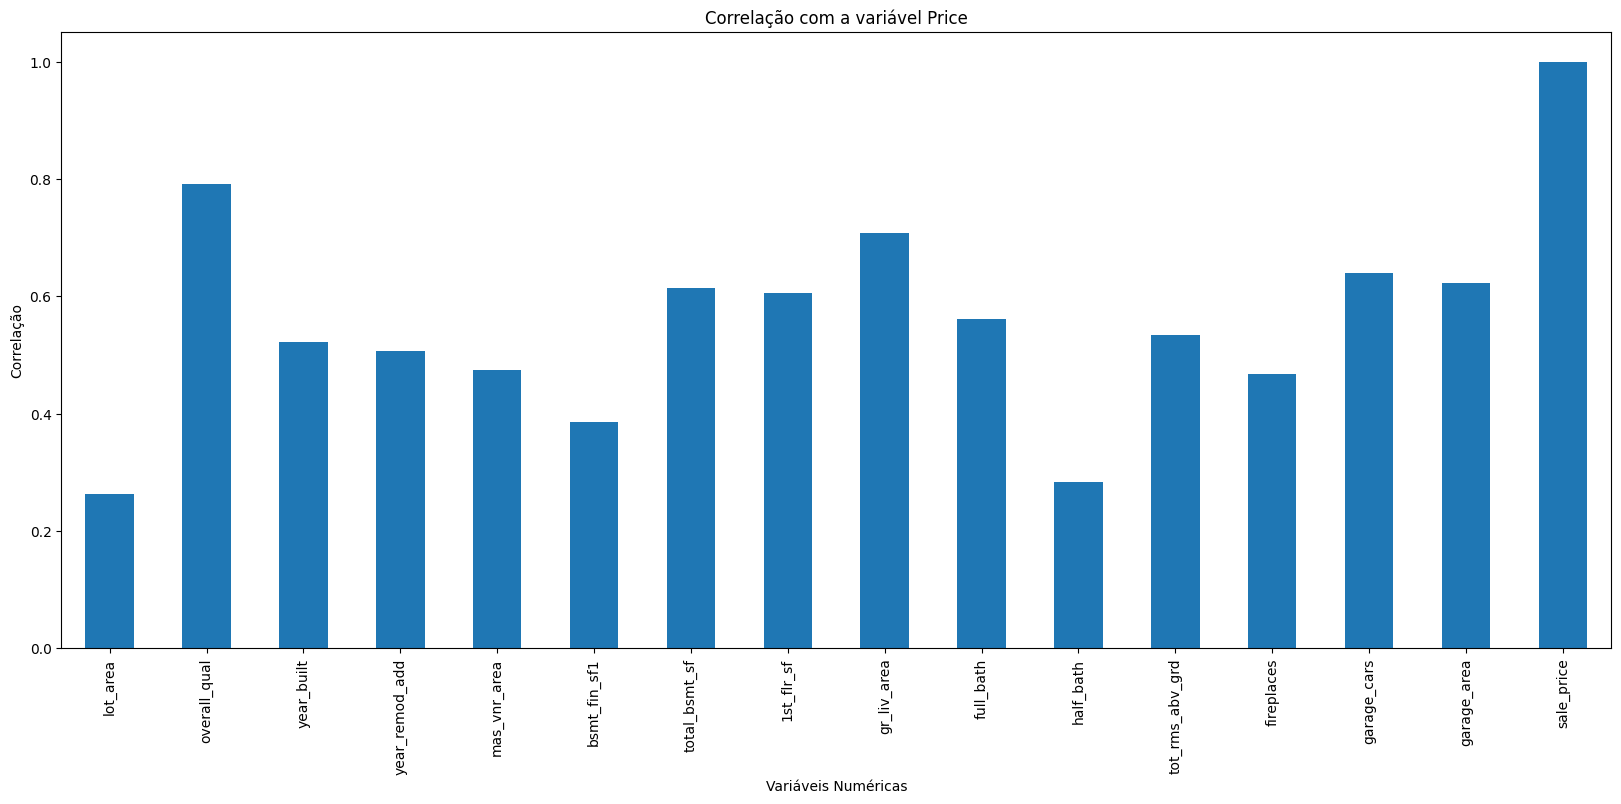

In [ ]:
# Correlação entre as variáveis numéricas e a variável alvo (price) após drop colunas irrelevantes
correlation_with_price = num_attributes.corrwith(df3['sale_price'])

plt.figure(figsize=(20, 8))
correlation_with_price.plot(kind='bar')
plt.title('Correlação com a variável Price')
plt.xlabel('Variáveis Numéricas')
plt.ylabel('Correlação')
plt.show()

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# Lista de variáveis categóricas
categorical_vars = ['ms_zoning', 'street', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition1', 'condition2',
       'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior1st',
       'exterior2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation',
       'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type1',
       'bsmt_fin_type2', 'heating', 'heating_qc', 'central_air', 'electrical',
       'kitchen_qual', 'functional', 'fireplace_qu', 'garage_type',
       'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive',
       'sale_type', 'sale_condition']

# Criando um DataFrame para armazenar os valores de Cramér's V
cramers_v_values = {}

# Calculando a correlação de Cramér's V entre cada variável categórica e sale_price
for var in categorical_vars:
    cramers_v_values[var] = cramers_v(cat_attributes[var], num_attributes['sale_price'])

# Exibindo os valores de Cramér's V
for var, value in cramers_v_values.items():
    print(f"{var}: {value:.4f}")

ms_zoning: 0.2924
street: 0.3935
lot_shape: 0.3240
land_contour: 0.1394
utilities: 0.0000
lot_config: 0.1448
land_slope: 0.1481
neighborhood: 0.1703
condition1: 0.0000
condition2: 0.1154
bldg_type: 0.0000
house_style: 0.0000
roof_style: 0.0000
roof_matl: 0.0000
exterior1st: 0.0000
exterior2nd: 0.0000
mas_vnr_type: 0.2646
exter_qual: 0.4442
exter_cond: 0.3054
foundation: 0.2215
bsmt_qual: 0.3921
bsmt_cond: 0.3335
bsmt_exposure: 0.2805
bsmt_fin_type1: 0.0000
bsmt_fin_type2: 0.0000
heating: 0.3496
heating_qc: 0.0000
central_air: 0.3357
electrical: 0.1417
kitchen_qual: 0.4343
functional: 0.0000
fireplace_qu: 0.2471
garage_type: 0.0549
garage_finish: 0.3658
garage_qual: 0.0890
garage_cond: 0.0000
paved_drive: 0.0000
sale_type: 0.2625
sale_condition: 0.2962


In [ ]:
# Colunas categóricas irrelevantes
irrelevant_cols_cat = [ 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition1', 'condition2',
       'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior1st',
       'exterior2nd', 'mas_vnr_type', 'foundation',
       'bsmt_exposure', 'bsmt_fin_type1',
       'bsmt_fin_type2', 'heating_qc',  'electrical',
        'functional', 'fireplace_qu', 'garage_type',
        'garage_qual', 'garage_cond', 'paved_drive',]
cat_attributes = cat_attributes.drop(columns=irrelevant_cols_cat)

In [ ]:
print(cat_attributes.columns)

Index(['ms_zoning', 'street', 'lot_shape', 'exter_qual', 'exter_cond',
       'bsmt_qual', 'bsmt_cond', 'heating', 'central_air', 'kitchen_qual',
       'garage_finish', 'sale_type', 'sale_condition'],
      dtype='object')


# 4.0. EDA - ANALISE EXPLORATORIA DOS DADOS

In [32]:
df4 = df3.copy()

In [113]:
df4.head()

id  ms_sub_class ms_zoning  lot_frontage  lot_area street lot_shape  \
0   1            60        RL          65.0      8450   Pave       Reg   
1   2            20        RL          80.0      9600   Pave       Reg   
2   3            60        RL          68.0     11250   Pave       IR1   
3   4            70        RL          60.0      9550   Pave       IR1   
4   5            60        RL          84.0     14260   Pave       IR1   

  land_contour utilities lot_config  ... yr_sold sale_type sale_condition  \
0          Lvl    AllPub     Inside  ...    2008        WD         Normal   
1          Lvl    AllPub        FR2  ...    2007        WD         Normal   
2          Lvl    AllPub     Inside  ...    2008        WD         Normal   
3          Lvl    AllPub     Corner  ...    2006        WD        Abnorml   
4          Lvl    AllPub        FR2  ...    2008        WD         Normal   

  sale_price age fireplaces_  pool  2nd_flr  veener  total_bathrooms  
0     208500   5           0     0        1       1                4  
1     181500  31           1     0        0       0                3  
2     223500   7           1     0        1       1                4  
3     140000  91           1     0        1       0                2  
4     250000   8           1     0        1       1                4  

[5 rows x 83 columns]

## 4.1 Analise Univariada

### 4.1.1 Response Variable

<Axes: xlabel='sale_price'>

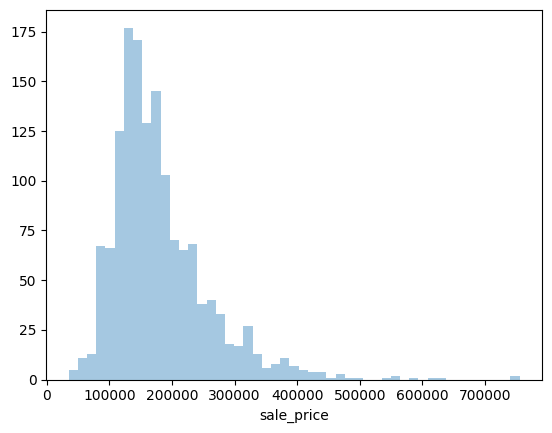

In [ ]:
sns.distplot (df4['sale_price'], kde=False)

### 4.1.2 Numerical Variable

array([[<Axes: title={'center': 'lot_area'}>,
        <Axes: title={'center': 'overall_qual'}>,
        <Axes: title={'center': 'year_built'}>,
        <Axes: title={'center': 'year_remod_add'}>],
       [<Axes: title={'center': 'mas_vnr_area'}>,
        <Axes: title={'center': 'bsmt_fin_sf1'}>,
        <Axes: title={'center': 'total_bsmt_sf'}>,
        <Axes: title={'center': '1st_flr_sf'}>],
       [<Axes: title={'center': 'gr_liv_area'}>,
        <Axes: title={'center': 'full_bath'}>,
        <Axes: title={'center': 'half_bath'}>,
        <Axes: title={'center': 'tot_rms_abv_grd'}>],
       [<Axes: title={'center': 'fireplaces'}>,
        <Axes: title={'center': 'garage_cars'}>,
        <Axes: title={'center': 'garage_area'}>,
        <Axes: title={'center': 'sale_price'}>]], dtype=object)

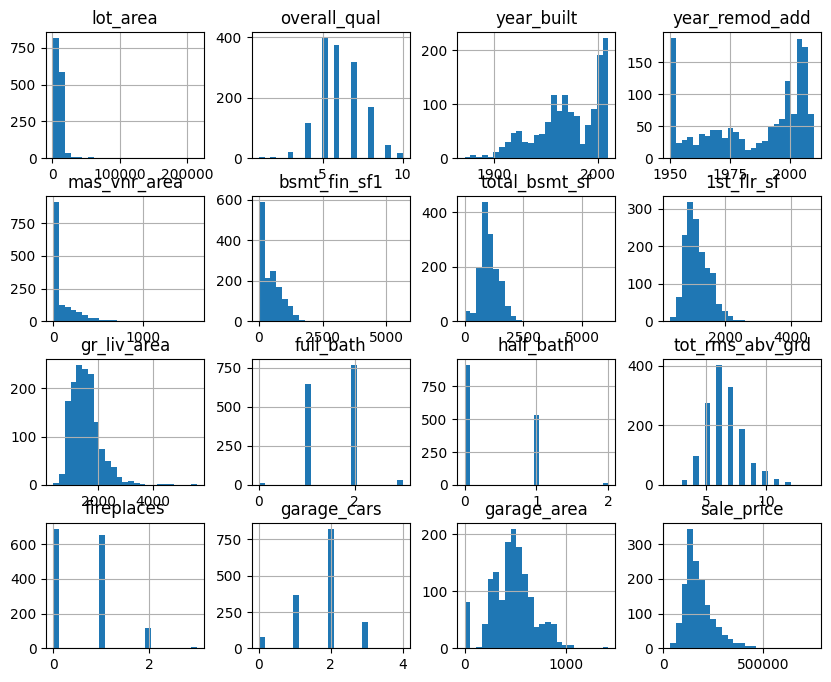

In [ ]:
num_attributes.hist(bins=25, figsize=(10, 8))

### 4.1.3 Categorical Variable

In [ ]:
cat_attributes.head()

ms_zoning street lot_shape exter_qual exter_cond bsmt_qual bsmt_cond  \
0        RL   Pave       Reg         Gd         TA        Gd        TA   
1        RL   Pave       Reg         TA         TA        Gd        TA   
2        RL   Pave       IR1         Gd         TA        Gd        TA   
3        RL   Pave       IR1         TA         TA        TA        Gd   
4        RL   Pave       IR1         Gd         TA        Gd        TA   

  heating central_air kitchen_qual garage_finish sale_type sale_condition  
0    GasA           Y           Gd           RFn        WD         Normal  
1    GasA           Y           TA           RFn        WD         Normal  
2    GasA           Y           Gd           RFn        WD         Normal  
3    GasA           Y           Gd           Unf        WD        Abnorml  
4    GasA           Y           Gd           RFn        WD         Normal

## 4.2 Analise Bivariada

##### 1.O momento da venda pode afetar os preços, com possíveis variações sazonais.
True - Realmente há meses em que há mais vendas que outros meses, e nesses meses com mais vendas houve redução de preço.

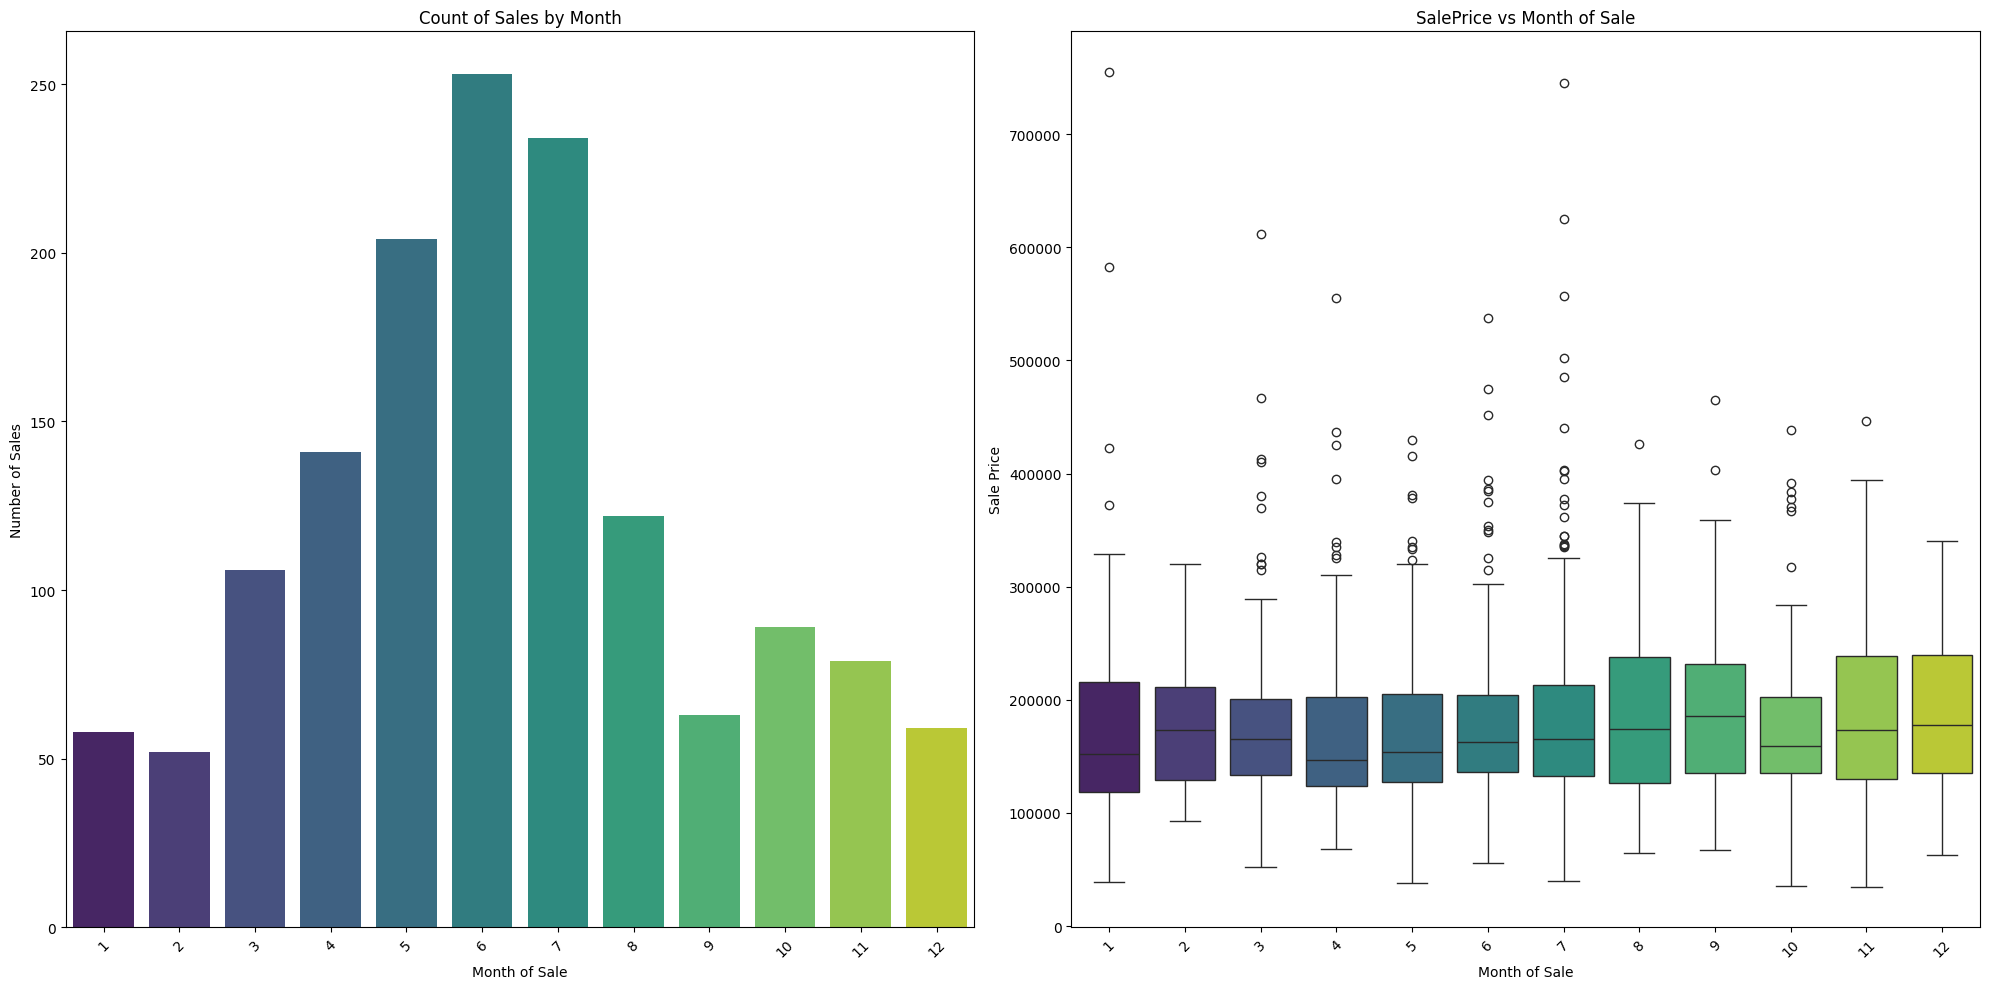

In [ ]:
# Ajustando o tamanho da figura
plt.figure(figsize=(20, 10))

grid = GridSpec(1, 2)

# Contagem de ocorrências por mês de venda
aux1 = df4[['mo_sold', 'sale_price']].groupby('mo_sold').count().reset_index()

plt.subplot(grid[0, 0])
sns.barplot(x='mo_sold', y='sale_price', data=aux1, palette='viridis')
plt.title('Count of Sales by Month')
plt.xlabel('Month of Sale')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)

# Gráfico de caixa para comparar os preços de venda por mês
plt.subplot(grid[0, 1])
sns.boxplot(x='mo_sold', y='sale_price', data=df4, palette='viridis')
plt.title('SalePrice vs Month of Sale')
plt.xlabel('Month of Sale')
plt.ylabel('Sale Price')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

##### 2.0 Vendas com financiamento convencional (WD) podem ter preços diferentes em comparação com vendas à vista (CWD) ou contratos especiais (Con, ConLw, ConLI, ConLD).
True - Podemos comprovar isso observando medianas diferentes entre as condições.

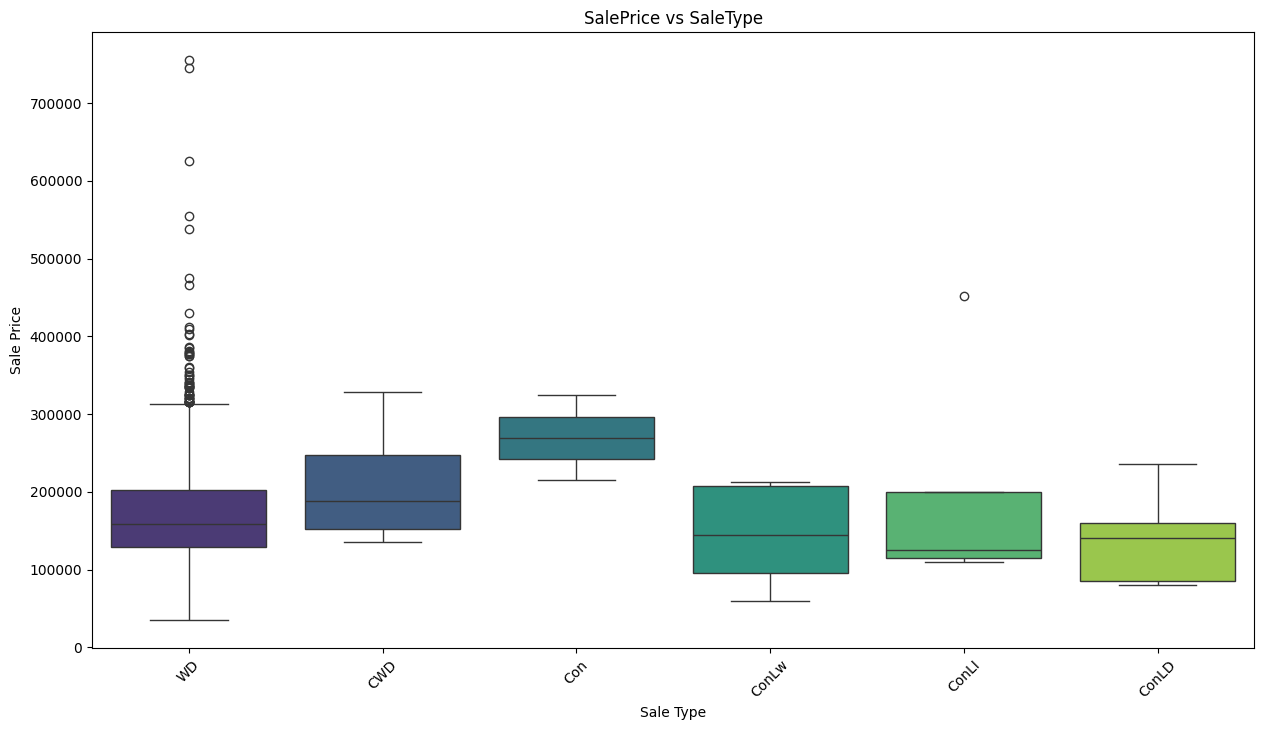

In [ ]:
# Ajustando o tamanho da figura
plt.figure(figsize=(15, 8))

# Gráfico de caixa para comparar os preços de venda por tipo de financiamento
sns.boxplot(x='sale_type', y='sale_price', data=df4, order=['WD', 'CWD', 'Con', 'ConLw', 'ConLI', 'ConLD'], palette='viridis')
plt.title('SalePrice vs SaleType')
plt.xlabel('Sale Type')
plt.ylabel('Sale Price')
plt.xticks(rotation=45)
plt.show()

##### 3.0 Propriedades vendidas como "New" (novas construções) podem ter preços mais altos devido ao valor percebido de uma casa recém-construída.
True - Podemos comprovar isso observando medianas diferentes entre as condições.

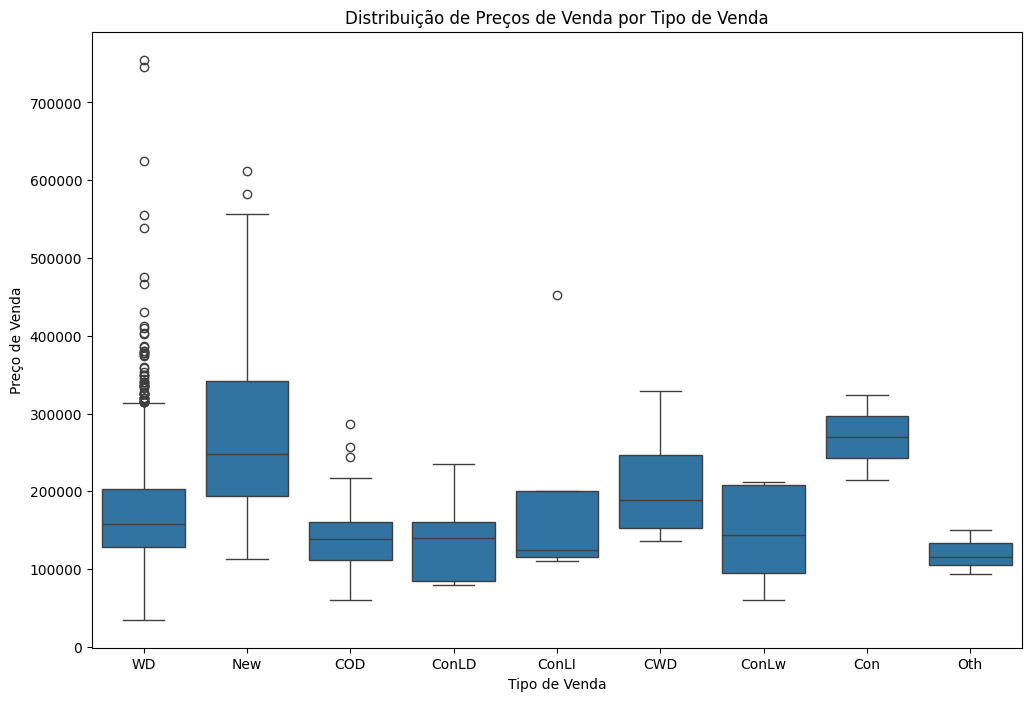

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='sale_type', y='sale_price', data=df4)
plt.title('Distribuição de Preços de Venda por Tipo de Venda')
plt.xlabel('Tipo de Venda')
plt.ylabel('Preço de Venda')
plt.show()

##### 4.0  Propriedades com lotes maiores tendem a ter preços mais altos devido ao espaço adicional e potencial para expansão.
False - A maioria  dos lotes tem um tamanho parecido, e o preço do imóvel pode ser mais alto devido a outros fatores.

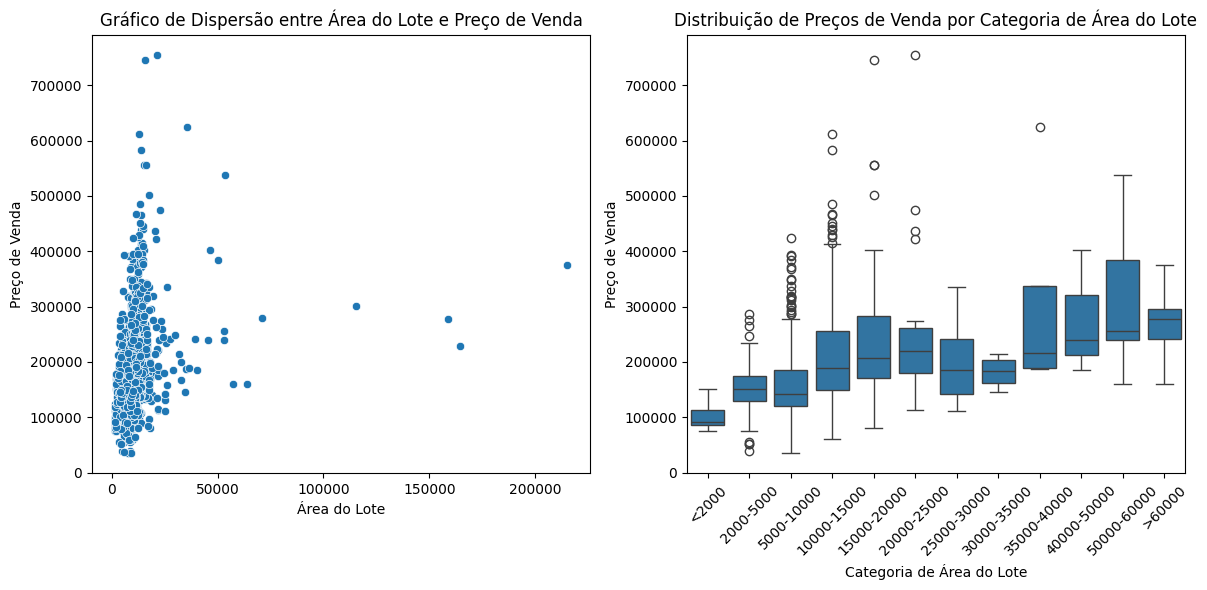

In [ ]:
# Gráfico de Dispersão entre Área do Lote e Preço de Venda
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x='lot_area', y='sale_price', data=df4)
plt.title('Gráfico de Dispersão entre Área do Lote e Preço de Venda')
plt.xlabel('Área do Lote')
plt.ylabel('Preço de Venda')

# Boxplot Segmentado por Categoria de Área do Lote
plt.subplot(1, 3, 2)

# Criar categorias de área do lote
df4['LotAreaCategory'] = pd.cut(df4['lot_area'], 
                                bins=[0 ,2000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 50000, 60000, float('inf')],
                                labels=['<2000','2000-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000', 
                                        '25000-30000', '30000-35000', '35000-40000', '40000-50000', '50000-60000', '>60000'])

sns.boxplot(x='LotAreaCategory', y='sale_price', data=df4)
plt.title('Distribuição de Preços de Venda por Categoria de Área do Lote')
plt.xlabel('Categoria de Área do Lote')
plt.ylabel('Preço de Venda')
plt.xticks(rotation=45)



plt.tight_layout()
plt.show()


##### 5.0 A qualidade geral dos materiais e acabamentos tem uma correlação positiva com o preço de venda. Propriedades com classificação de qualidade mais alta podem ter preços mais elevados.
True

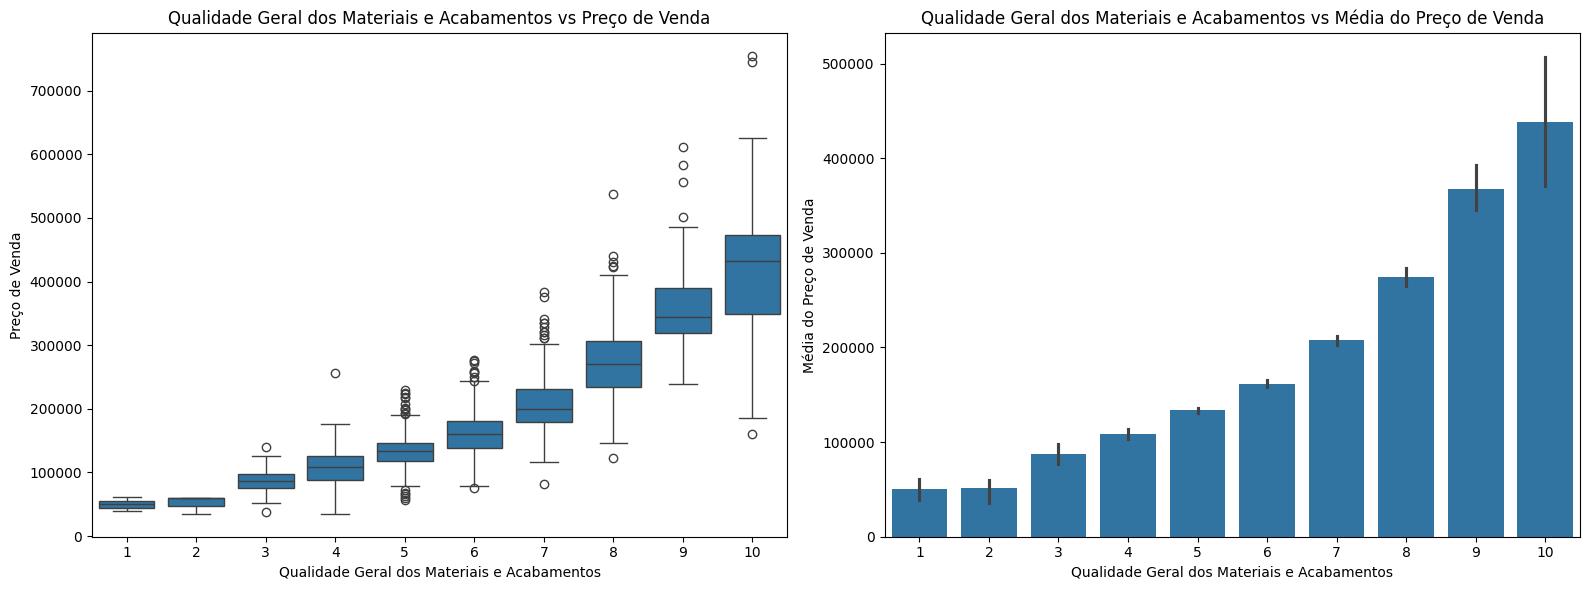

In [ ]:
plt.figure(figsize=(16, 6))

# Gráfico de Boxplot da Qualidade Geral dos Materiais e Acabamentos vs Preço de Venda
plt.subplot(1, 2, 1)
sns.boxplot(x='overall_qual', y='sale_price', data=df4)
plt.title('Qualidade Geral dos Materiais e Acabamentos vs Preço de Venda')
plt.xlabel('Qualidade Geral dos Materiais e Acabamentos')
plt.ylabel('Preço de Venda')

# Gráfico de Barras da Qualidade Geral dos Materiais e Acabamentos vs Média do Preço de Venda
plt.subplot(1, 2, 2)
sns.barplot(x='overall_qual', y='sale_price', data=df4, estimator=np.mean)
plt.title('Qualidade Geral dos Materiais e Acabamentos vs Média do Preço de Venda')
plt.xlabel('Qualidade Geral dos Materiais e Acabamentos')
plt.ylabel('Média do Preço de Venda')

plt.tight_layout()
plt.show()

##### 6.0 O número total de banheiros influencia o preço.
True - Até a quantidade de 4 banheiros podemos considerar que sim, ao aumentar a quantidade de banheiros o preço dos imóveis tende a subir.

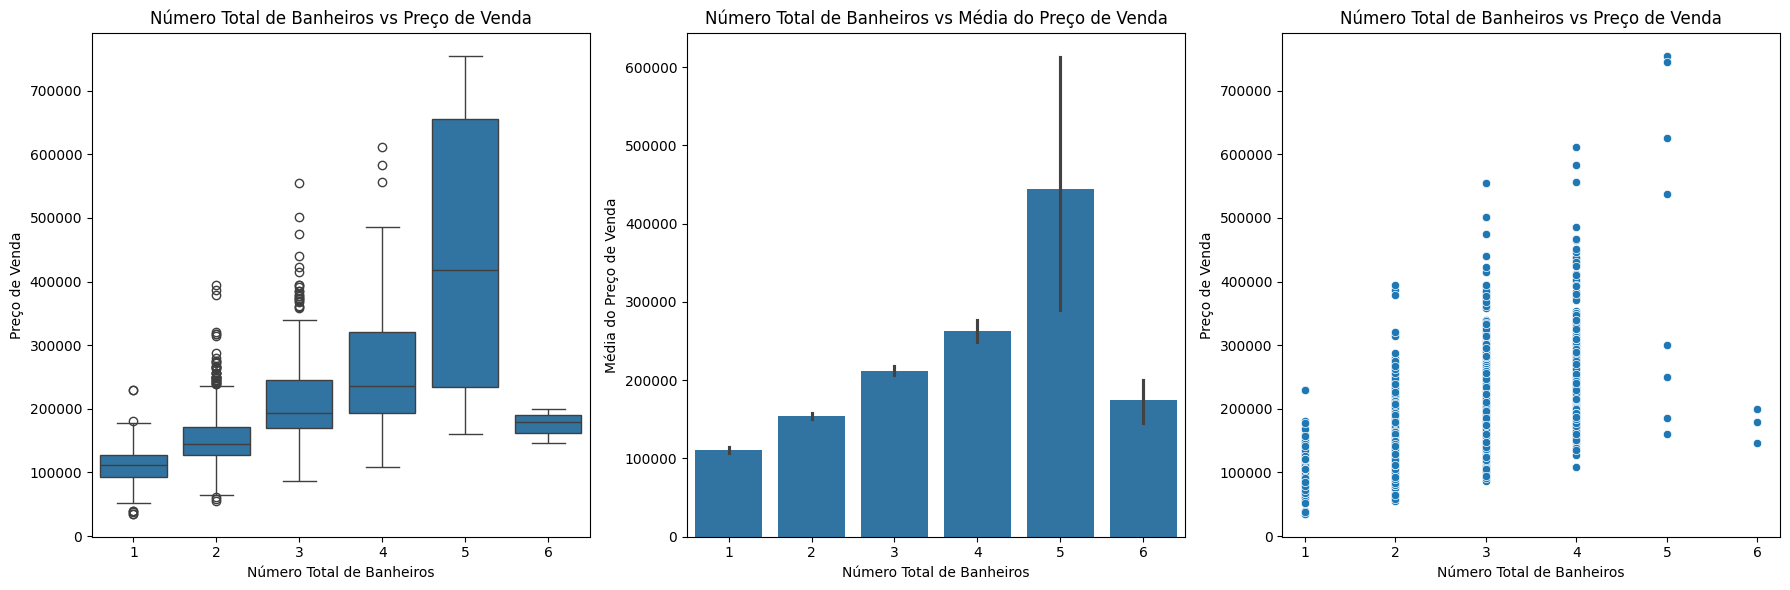

In [ ]:
# Definindo o tamanho da figura
plt.figure(figsize=(18, 6))

# Gráfico de Boxplot do Número Total de Banheiros vs Preço de Venda
plt.subplot(1, 3, 1)
sns.boxplot(x='total_bathrooms', y='sale_price', data=df4)
plt.title('Número Total de Banheiros vs Preço de Venda')
plt.xlabel('Número Total de Banheiros')
plt.ylabel('Preço de Venda')

# Gráfico de Barras do Número Total de Banheiros vs Média do Preço de Venda
plt.subplot(1, 3, 2)
sns.barplot(x='total_bathrooms', y='sale_price', data=df4, estimator=np.mean)
plt.title('Número Total de Banheiros vs Média do Preço de Venda')
plt.xlabel('Número Total de Banheiros')
plt.ylabel('Média do Preço de Venda')

# Gráfico de Dispersão do Número Total de Banheiros vs Preço de Venda
plt.subplot(1, 3, 3)
sns.scatterplot(x='total_bathrooms', y='sale_price', data=df4)
plt.title('Número Total de Banheiros vs Preço de Venda')
plt.xlabel('Número Total de Banheiros')
plt.ylabel('Preço de Venda')

plt.tight_layout()
plt.show()


##### 7.0 O número de quartos afeta o preço.
False 

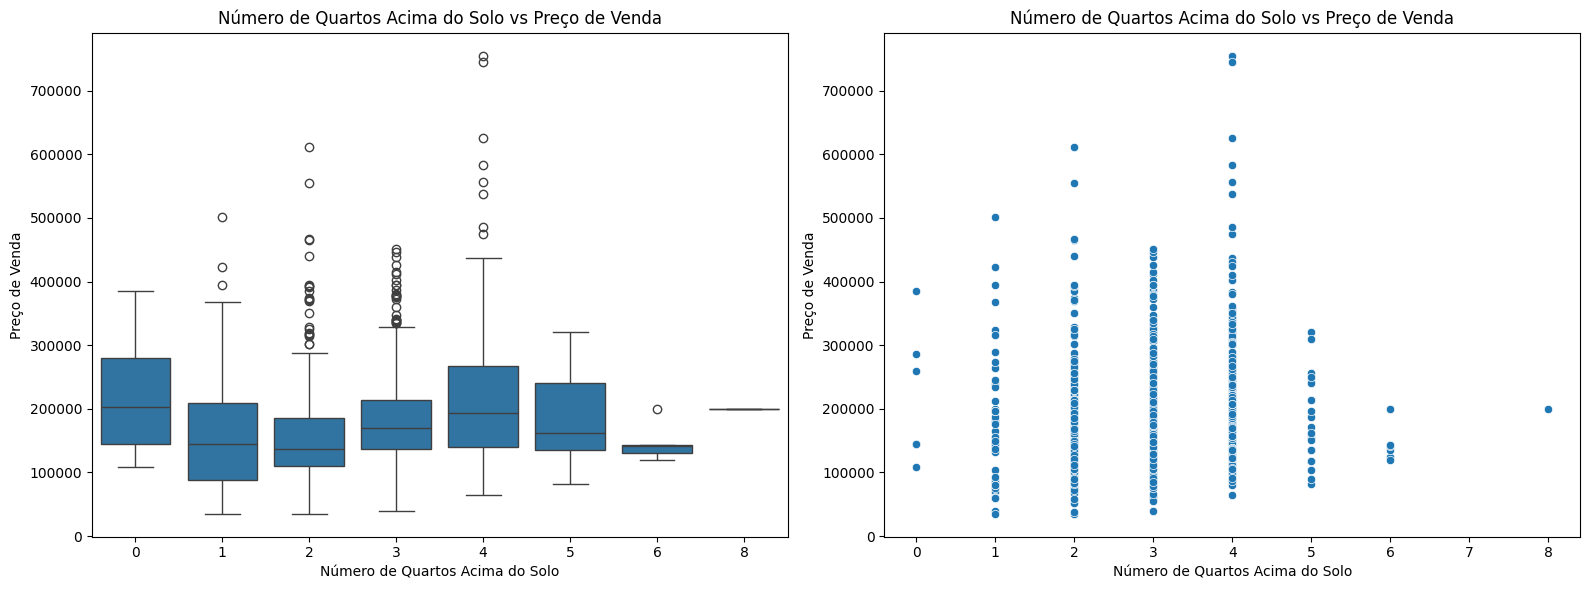

In [ ]:
plt.figure(figsize=(16, 6))

# Gráfico de Boxplot do Número de Quartos Acima do Solo vs Preço de Venda
plt.subplot(1, 2, 1)
sns.boxplot(x='bedroom_abv_gr', y='sale_price', data=df4)
plt.title('Número de Quartos Acima do Solo vs Preço de Venda')
plt.xlabel('Número de Quartos Acima do Solo')
plt.ylabel('Preço de Venda')

# Gráfico de Dispersão do Número de Quartos Acima do Solo vs Preço de Venda
plt.subplot(1, 2, 2)
sns.scatterplot(x='bedroom_abv_gr', y='sale_price', data=df4)
plt.title('Número de Quartos Acima do Solo vs Preço de Venda')
plt.xlabel('Número de Quartos Acima do Solo')
plt.ylabel('Preço de Venda')

plt.tight_layout()
plt.show()

##### 8.0  A presença de lareiras pode influenciar o aumento no preço.
True - Influencia o preço, porém muito pouco.

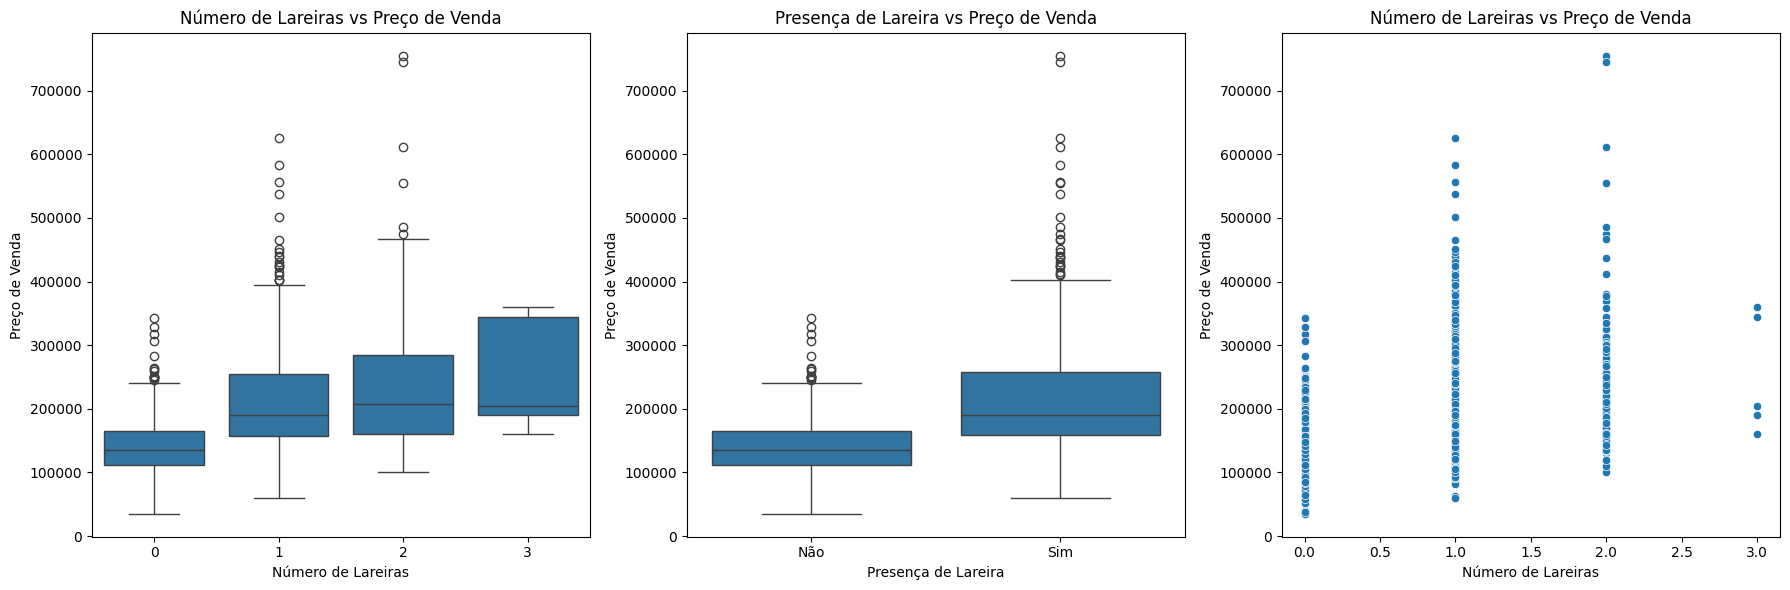

In [ ]:
# Definindo o tamanho da figura
plt.figure(figsize=(18, 6))

# Gráfico de Boxplot do Número de Lareiras vs Preço de Venda
plt.subplot(1, 3, 1)
sns.boxplot(x='fireplaces', y='sale_price', data=df4)
plt.title('Número de Lareiras vs Preço de Venda')
plt.xlabel('Número de Lareiras')
plt.ylabel('Preço de Venda')

# Gráfico de Boxplot da Presença de Lareira vs Preço de Venda
plt.subplot(1, 3, 2)
sns.boxplot(x='fireplaces_', y='sale_price', data=df4)
plt.title('Presença de Lareira vs Preço de Venda')
plt.xlabel('Presença de Lareira')
plt.ylabel('Preço de Venda')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])

# Gráfico de Dispersão do Número de Lareiras vs Preço de Venda
plt.subplot(1, 3, 3)
sns.scatterplot(x='fireplaces', y='sale_price', data=df4)
plt.title('Número de Lareiras vs Preço de Venda')
plt.xlabel('Número de Lareiras')
plt.ylabel('Preço de Venda')

plt.tight_layout()
plt.show()

##### 9.0 Sistemas de aquecimento e ar condicionado eficientes e de alta qualidade podem aumentar o preço do imóvel.
True - A qualidade e existência do sistema de aquecimento pode influenciar o preço dos imóveis, mas a existência do ar condicionado não influencia.

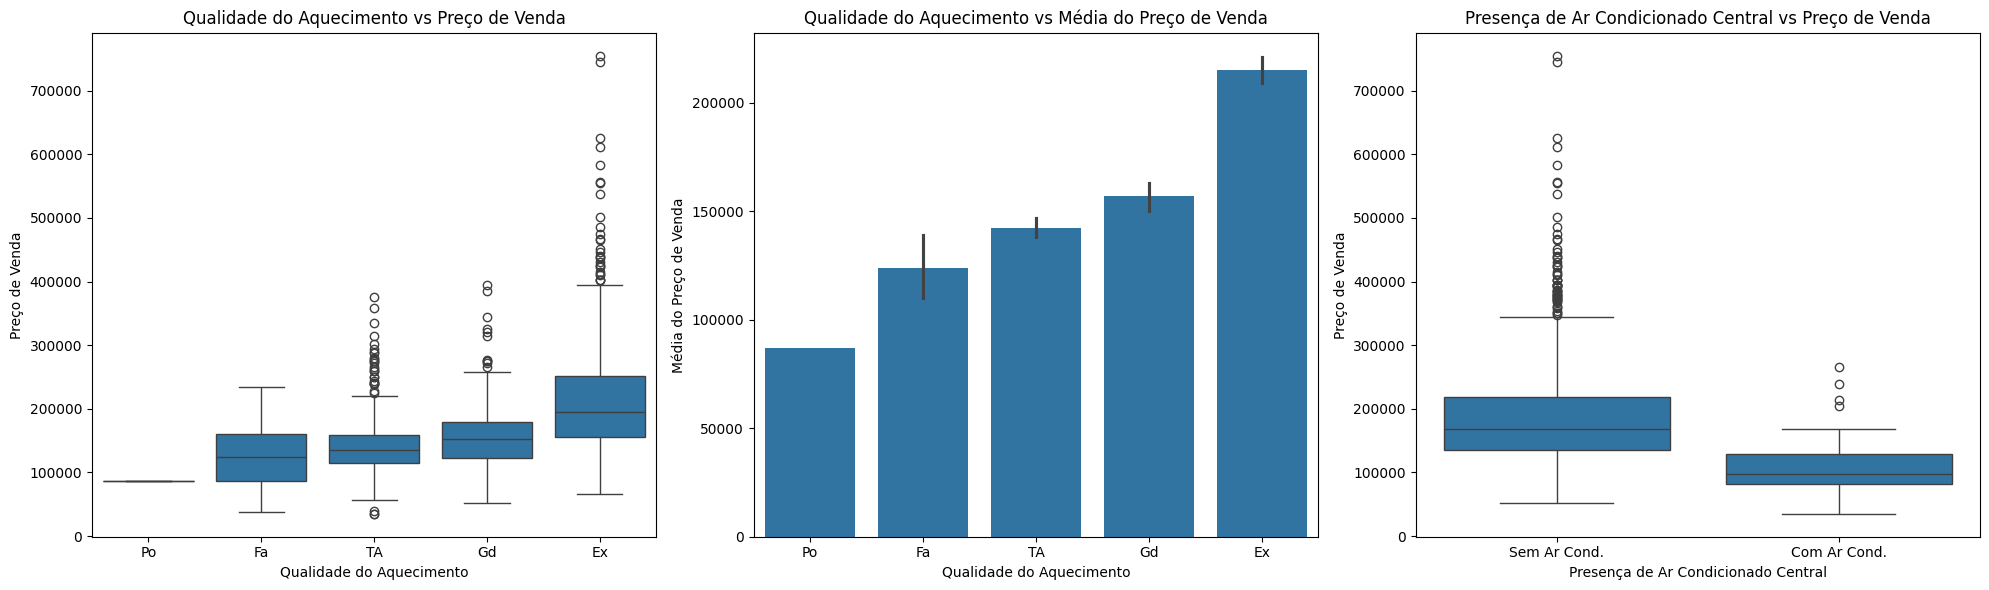

In [ ]:
# Definindo o tamanho da figura
plt.figure(figsize=(20, 6))

# Gráfico de Boxplot da Qualidade do Aquecimento vs Preço de Venda
plt.subplot(1, 3, 1)
sns.boxplot(x='heating_qc', y='sale_price', data=df4, order=['Po', 'Fa', 'TA', 'Gd', 'Ex'])
plt.title('Qualidade do Aquecimento vs Preço de Venda')
plt.xlabel('Qualidade do Aquecimento')
plt.ylabel('Preço de Venda')

# Gráfico de Barras da Qualidade do Aquecimento vs Média do Preço de Venda
plt.subplot(1, 3, 2)
sns.barplot(x='heating_qc', y='sale_price', data=df4, order=['Po', 'Fa', 'TA', 'Gd', 'Ex'], estimator=np.mean)
plt.title('Qualidade do Aquecimento vs Média do Preço de Venda')
plt.xlabel('Qualidade do Aquecimento')
plt.ylabel('Média do Preço de Venda')

# Gráfico de Boxplot da Presença de Ar Condicionado Central vs Preço de Venda
plt.subplot(1, 3, 3)
sns.boxplot(x='central_air', y='sale_price', data=df4)
plt.title('Presença de Ar Condicionado Central vs Preço de Venda')
plt.xlabel('Presença de Ar Condicionado Central')
plt.ylabel('Preço de Venda')
plt.xticks(ticks=[0, 1], labels=['Sem Ar Cond.', 'Com Ar Cond.'])

plt.tight_layout()
plt.show()

##### 10.0 Data de construção original (YearBuilt). Quanto mais antigo mais barato o imóvel.
True

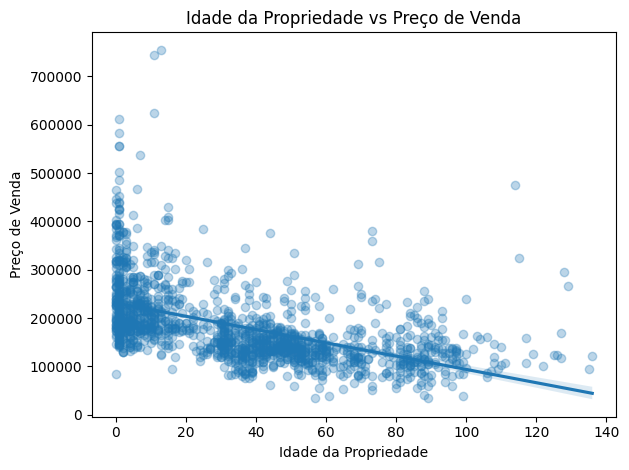

In [ ]:
# Gráfico de Dispersão de Age vs Preço de Venda com linha de tendência
sns.regplot(x='age', y='sale_price', data=df4, scatter_kws={'alpha':0.3})
plt.title('Idade da Propriedade vs Preço de Venda')
plt.xlabel('Idade da Propriedade')
plt.ylabel('Preço de Venda')

plt.tight_layout()
plt.show()

# 5.0. DATA PREPARATION

In [33]:
df5 = df4[num_attributes.columns.tolist() + cat_attributes.columns.tolist()+feature_engineered_cols].copy()

In [ ]:
print (num_attributes.columns)

Index(['lot_area', 'overall_qual', 'year_built', 'year_remod_add',
       'mas_vnr_area', 'bsmt_fin_sf1', 'total_bsmt_sf', '1st_flr_sf',
       'gr_liv_area', 'full_bath', 'half_bath', 'tot_rms_abv_grd',
       'fireplaces', 'garage_cars', 'garage_area', 'sale_price'],
      dtype='object')


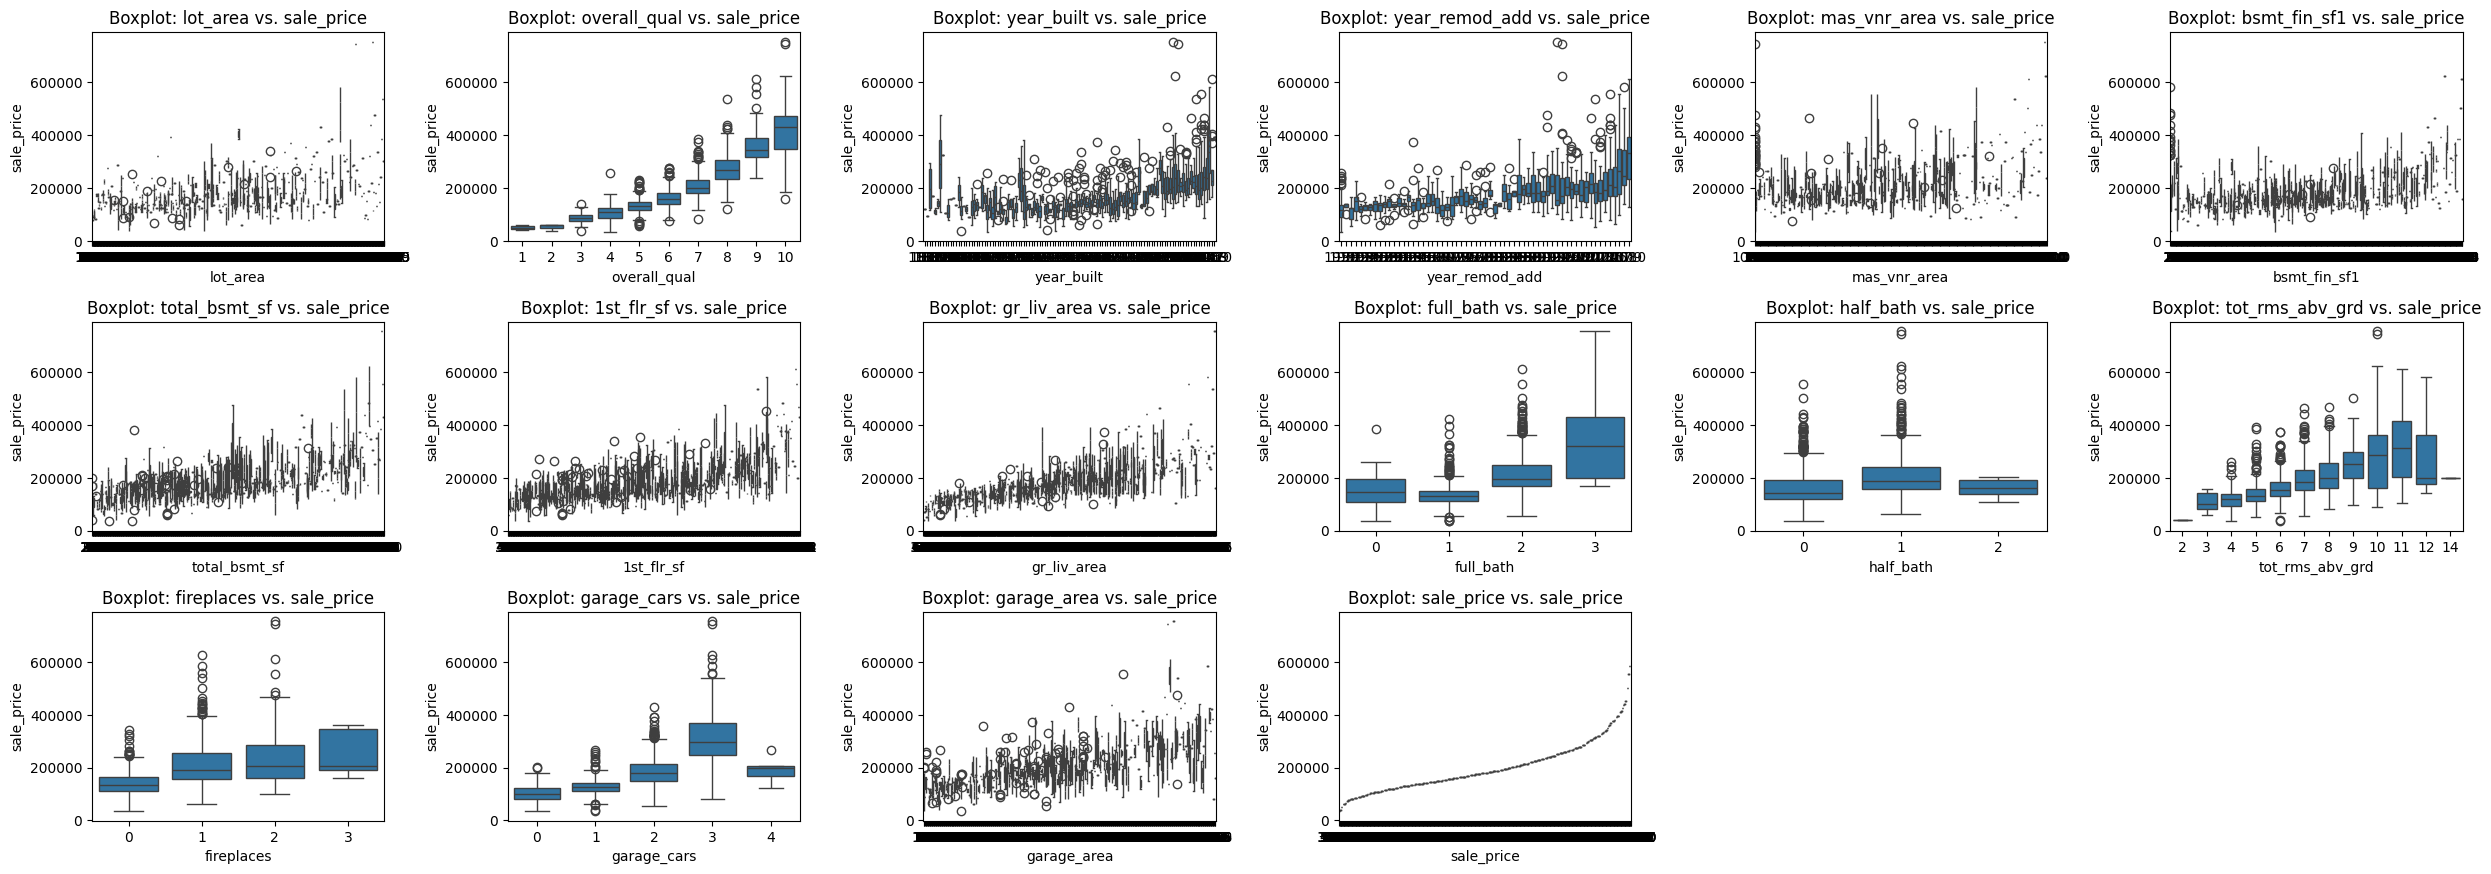

In [ ]:
# Boxplot
plt.figure(figsize=(25, 20))

for i, variable in enumerate(num_attributes.columns, 1):
    plt.subplot(7, 6, i)
    sns.boxplot(x=variable, y='sale_price', data=df5)
    plt.title(f'Boxplot: {variable} vs. sale_price')

plt.tight_layout()
plt.show()

In [ ]:
print (cat_attributes.columns)

Index(['ms_zoning', 'street', 'lot_shape', 'exter_qual', 'exter_cond',
       'bsmt_qual', 'bsmt_cond', 'heating', 'central_air', 'kitchen_qual',
       'garage_finish', 'sale_type', 'sale_condition'],
      dtype='object')


## 5.1. Normalizacao

## 5.2. Rescaling

In [ ]:
print(os.getcwd())

c:\Users\PâmelaBotelhoMagalhã\OneDrive - Dataside\Documentos\Estudos\house_prices


In [34]:
if not os.path.exists('parameter'):
    os.makedirs('parameter')

rs = RobustScaler()

variables = ['lot_area', 'overall_qual', 'year_built', 'year_remod_add',
             'mas_vnr_area', 'bsmt_fin_sf1', 'total_bsmt_sf', '1st_flr_sf',
             'gr_liv_area', 'full_bath', 'half_bath', 'tot_rms_abv_grd',
             'fireplaces', 'garage_cars', 'garage_area']

for var in variables:
    df5[var] = rs.fit_transform(df5[[var]].values)
    with open(f'parameter/{var}_scaler.pkl', 'wb') as f:
        pickle.dump(rs, f)

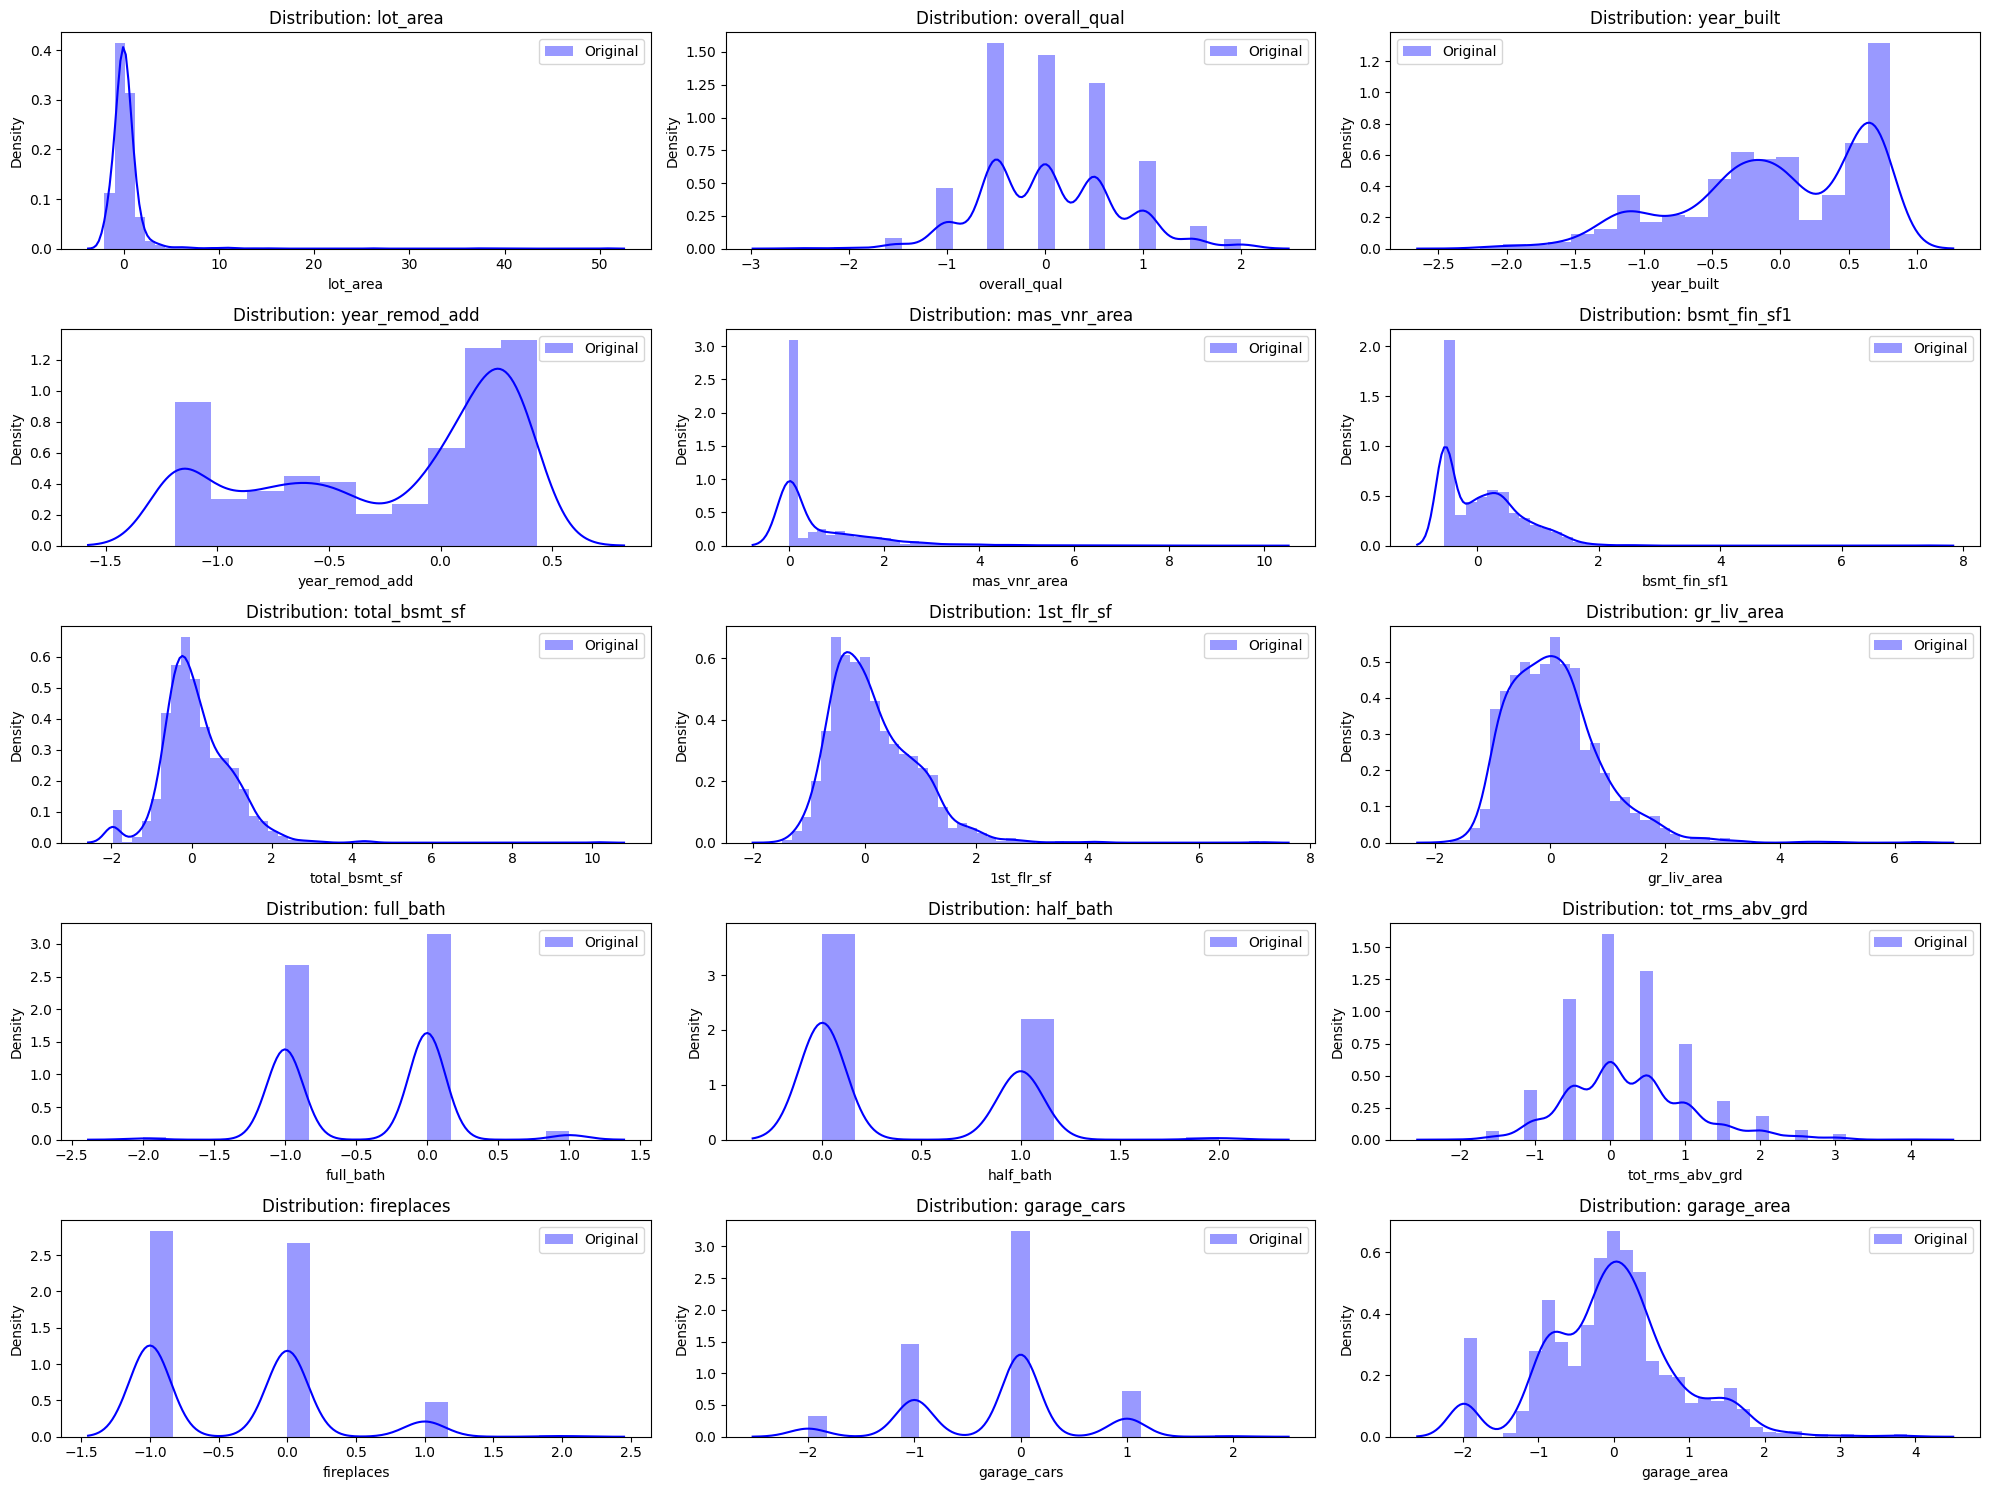

In [ ]:
#Verificando mudanças
plt.figure(figsize=(20, 15))

for i, var in enumerate(variables, 1):
    plt.subplot(5, 3, i)
    sns.distplot(df5[var], label='Original', color='blue')
    plt.title(f'Distribution: {var}')
    plt.legend()

plt.tight_layout()
plt.show()

## 5.3. Transformation

### 5.3.1 Encoding

In [75]:
df5.head()

id  ms_sub_class  lot_frontage  lot_area  overall_qual  overall_cond  \
0   1            60          65.0      8450             7             5   
1   2            20          80.0      9600             6             8   
2   3            60          68.0     11250             7             5   
3   4            70          60.0      9550             7             5   
4   5            60          84.0     14260             8             5   

   year_built  year_remod_add  mas_vnr_area  bsmt_fin_sf1  ...  garage_cond  \
0        2003            2003         196.0           706  ...            4   
1        1976            1976           0.0           978  ...            4   
2        2001            2002         162.0           486  ...            4   
3        1915            1970           0.0           216  ...            4   
4        2000            2000         350.0           655  ...            4   

   paved_drive  sale_type  sale_condition  age  pool  2nd_flr  \
0            2          8               4    5     0        1   
1            2          8               4   31     0        0   
2            2          8               4    7     0        1   
3            2          8               0   91     0        1   
4            2          8               4    8     0        1   

   total_bathrooms  fireplaces_  veener  
0                4            0       1  
1                3            1       0  
2                4            1       1  
3                2            1       0  
4                4            1       1  

[5 rows x 82 columns]

In [183]:
cat_attributes.shape

(1460, 39)

In [184]:
cat_attributes.columns

Index(['ms_zoning', 'street', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition1', 'condition2',
       'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior1st',
       'exterior2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation',
       'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type1',
       'bsmt_fin_type2', 'heating', 'heating_qc', 'central_air', 'electrical',
       'kitchen_qual', 'functional', 'fireplace_qu', 'garage_type',
       'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive',
       'sale_type', 'sale_condition'],
      dtype='object')

In [81]:
cat_attributes.head()

ms_zoning street lot_shape land_contour utilities lot_config land_slope  \
0        RL   Pave       Reg          Lvl    AllPub     Inside        Gtl   
1        RL   Pave       Reg          Lvl    AllPub        FR2        Gtl   
2        RL   Pave       IR1          Lvl    AllPub     Inside        Gtl   
3        RL   Pave       IR1          Lvl    AllPub     Corner        Gtl   
4        RL   Pave       IR1          Lvl    AllPub        FR2        Gtl   

  neighborhood condition1 condition2  ... kitchen_qual functional  \
0      CollgCr       Norm       Norm  ...           Gd        Typ   
1      Veenker      Feedr       Norm  ...           TA        Typ   
2      CollgCr       Norm       Norm  ...           Gd        Typ   
3      Crawfor       Norm       Norm  ...           Gd        Typ   
4      NoRidge       Norm       Norm  ...           Gd        Typ   

  fireplace_qu garage_type garage_finish garage_qual garage_cond paved_drive  \
0           TA      Attchd           RFn          TA          TA           Y   
1           TA      Attchd           RFn          TA          TA           Y   
2           TA      Attchd           RFn          TA          TA           Y   
3           Gd      Detchd           Unf          TA          TA           Y   
4           TA      Attchd           RFn          TA          TA           Y   

  sale_type sale_condition  
0        WD         Normal  
1        WD         Normal  
2        WD         Normal  
3        WD        Abnorml  
4        WD         Normal  

[5 rows x 39 columns]

In [185]:
cat_attributes.dtypes

ms_zoning         object
street            object
lot_shape         object
land_contour      object
utilities         object
lot_config        object
land_slope        object
neighborhood      object
condition1        object
condition2        object
bldg_type         object
house_style       object
roof_style        object
roof_matl         object
exterior1st       object
exterior2nd       object
mas_vnr_type      object
exter_qual        object
exter_cond        object
foundation        object
bsmt_qual         object
bsmt_cond         object
bsmt_exposure     object
bsmt_fin_type1    object
bsmt_fin_type2    object
heating           object
heating_qc        object
central_air       object
electrical        object
kitchen_qual      object
functional        object
fireplace_qu      object
garage_type       object
garage_finish     object
garage_qual       object
garage_cond       object
paved_drive       object
sale_type         object
sale_condition    object
dtype: object

In [35]:
# Label Encoding
le = LabelEncoder()

vars_to_labelencoder = [ 'street', 'central_air','sale_condition','exter_qual','exter_cond','bsmt_qual','bsmt_cond',
'kitchen_qual','fireplace_qu','garage_qual','garage_cond']

for var in vars_to_labelencoder:
    df5[var] = le.fit_transform(df5[var])

# One hot encoding
vars_to_onehot = [ 'land_contour','utilities','lot_config','land_slope','neighborhood',
                   'condition1' ,'condition2','bldg_type','house_style','roof_style','roof_matl','exterior1st','exterior2nd','mas_vnr_type',
                   'foundation','bsmt_exposure','bsmt_fin_type1','bsmt_fin_type2','heating','electrical','functional','garage_type','garage_finish',
                   'paved_drive','sale_type','sale_condition', 'lot_shape','ms_zoning','heating_qc']

df5_encoded = pd.get_dummies(df5, columns=vars_to_onehot)


#'exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'heating_qc', 'kitchen_qual', 'fireplace_qu', 'garage_qual' , 'garage_cond'
# Ordinal Encoding





#mapping_ordinal = {
    #'exter_qual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    #'exter_cond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    #'bsmt_qual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'NA': 0},
    #'bsmt_cond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'NA': 0},
    #'heating_qc': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    #'kitchen_qual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    #'fireplace_qu': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'NA': 0},
    #'garage_qual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'NA': 0},
    #'garage_cond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'NA': 0},}

# Aplicação do mapeamento ordinal
#for var, mapping in mapping_ordinal.items():
    #df5[var] = df5[var].str.lower()  # Converter para minúsculas
    #df5[var] = df5[var].map(mapping)


In [36]:
cat_attributes.head()

ms_zoning street lot_shape land_contour utilities lot_config land_slope  \
0        RL   Pave       Reg          Lvl    AllPub     Inside        Gtl   
1        RL   Pave       Reg          Lvl    AllPub        FR2        Gtl   
2        RL   Pave       IR1          Lvl    AllPub     Inside        Gtl   
3        RL   Pave       IR1          Lvl    AllPub     Corner        Gtl   
4        RL   Pave       IR1          Lvl    AllPub        FR2        Gtl   

  neighborhood condition1 condition2  ... kitchen_qual functional  \
0      CollgCr       Norm       Norm  ...           Gd        Typ   
1      Veenker      Feedr       Norm  ...           TA        Typ   
2      CollgCr       Norm       Norm  ...           Gd        Typ   
3      Crawfor       Norm       Norm  ...           Gd        Typ   
4      NoRidge       Norm       Norm  ...           Gd        Typ   

  fireplace_qu garage_type garage_finish garage_qual garage_cond paved_drive  \
0           TA      Attchd           RFn          TA          TA           Y   
1           TA      Attchd           RFn          TA          TA           Y   
2           TA      Attchd           RFn          TA          TA           Y   
3           Gd      Detchd           Unf          TA          TA           Y   
4           TA      Attchd           RFn          TA          TA           Y   

  sale_type sale_condition  
0        WD         Normal  
1        WD         Normal  
2        WD         Normal  
3        WD        Abnorml  
4        WD         Normal  

[5 rows x 39 columns]

In [37]:
df5_encoded.head()

id  ms_sub_class  lot_frontage  lot_area  overall_qual  overall_cond  \
0   1            60          65.0 -0.254076           0.5             5   
1   2            20          80.0  0.030015           0.0             8   
2   3            60          68.0  0.437624           0.5             5   
3   4            70          60.0  0.017663           0.5             5   
4   5            60          84.0  1.181201           1.0             5   

   year_built  year_remod_add  mas_vnr_area  bsmt_fin_sf1  ...  \
0    0.652174        0.243243      1.193303      0.452790  ...   
1    0.065217       -0.486486      0.000000      0.834679  ...   
2    0.608696        0.216216      0.986301      0.143910  ...   
3   -1.260870       -0.648649      0.000000     -0.235170  ...   
4    0.586957        0.162162      2.130898      0.381186  ...   

   ms_zoning_C (all)  ms_zoning_FV  ms_zoning_RH  ms_zoning_RL  ms_zoning_RM  \
0              False         False         False          True         False   
1              False         False         False          True         False   
2              False         False         False          True         False   
3              False         False         False          True         False   
4              False         False         False          True         False   

   heating_qc_Ex  heating_qc_Fa  heating_qc_Gd  heating_qc_Po  heating_qc_TA  
0           True          False          False          False          False  
1           True          False          False          False          False  
2           True          False          False          False          False  
3          False          False           True          False          False  
4           True          False          False          False          False  

[5 rows x 252 columns]

In [38]:

df5_encoded.isnull().sum().sort_values(ascending=False).head(25)

id                      0
foundation_PConc        0
exterior2nd_Other       0
exterior2nd_Plywood     0
exterior2nd_Stone       0
exterior2nd_Stucco      0
exterior2nd_VinylSd     0
exterior2nd_Wd Sdng     0
exterior2nd_Wd Shng     0
mas_vnr_type_BrkCmn     0
mas_vnr_type_BrkFace    0
mas_vnr_type_None       0
mas_vnr_type_Stone      0
foundation_BrkTil       0
foundation_CBlock       0
foundation_Slab         0
exterior2nd_ImStucc     0
foundation_Stone        0
foundation_Wood         0
bsmt_exposure_Av        0
bsmt_exposure_Gd        0
bsmt_exposure_Mn        0
bsmt_exposure_No        0
bsmt_fin_type1_ALQ      0
bsmt_fin_type1_BLQ      0
dtype: int64

In [39]:
df5.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1460 non-null   int64  
 1   ms_sub_class     1460 non-null   int64  
 2   lot_frontage     1460 non-null   float64
 3   lot_area         1460 non-null   float64
 4   overall_qual     1460 non-null   float64
 5   overall_cond     1460 non-null   int64  
 6   year_built       1460 non-null   float64
 7   year_remod_add   1460 non-null   float64
 8   mas_vnr_area     1460 non-null   float64
 9   bsmt_fin_sf1     1460 non-null   float64
 10  bsmt_fin_sf2     1460 non-null   int64  
 11  bsmt_unf_sf      1460 non-null   int64  
 12  total_bsmt_sf    1460 non-null   float64
 13  1st_flr_sf       1460 non-null   float64
 14  2nd_flr_sf       1460 non-null   int64  
 15  low_qual_fin_sf  1460 non-null   int64  
 16  gr_liv_area      1460 non-null   float64
 17  bsmt_full_bath

In [40]:
df5['heating_qc'].value_counts()

heating_qc
Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: count, dtype: int64

In [199]:
cat_attributes.dtypes

ms_zoning         object
street            object
lot_shape         object
land_contour      object
utilities         object
lot_config        object
land_slope        object
neighborhood      object
condition1        object
condition2        object
bldg_type         object
house_style       object
roof_style        object
roof_matl         object
exterior1st       object
exterior2nd       object
mas_vnr_type      object
exter_qual        object
exter_cond        object
foundation        object
bsmt_qual         object
bsmt_cond         object
bsmt_exposure     object
bsmt_fin_type1    object
bsmt_fin_type2    object
heating           object
heating_qc        object
central_air       object
electrical        object
kitchen_qual      object
functional        object
fireplace_qu      object
garage_type       object
garage_finish     object
garage_qual       object
garage_cond       object
paved_drive       object
sale_type         object
sale_condition    object
dtype: object

### 5.3.2 Response Variable Transformation

<Axes: xlabel='sale_price', ylabel='Density'>

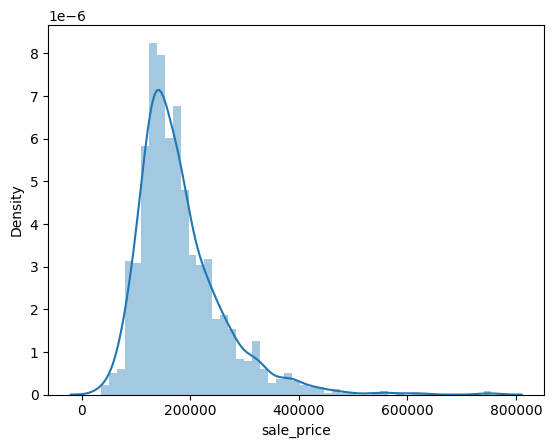

In [ ]:
sns.distplot(df5['sale_price'])

In [ ]:
#df5['sales'] = np.log1p(df5['sale_price'])
#sns.distplot(df5['sale_price'])


# 6.0. FEATURE SELECTION

In [60]:
df6 = df5_encoded.copy()

In [42]:
df6.head()

id  ms_sub_class  lot_frontage  lot_area  overall_qual  overall_cond  \
0   1            60          65.0 -0.254076           0.5             5   
1   2            20          80.0  0.030015           0.0             8   
2   3            60          68.0  0.437624           0.5             5   
3   4            70          60.0  0.017663           0.5             5   
4   5            60          84.0  1.181201           1.0             5   

   year_built  year_remod_add  mas_vnr_area  bsmt_fin_sf1  ...  \
0    0.652174        0.243243      1.193303      0.452790  ...   
1    0.065217       -0.486486      0.000000      0.834679  ...   
2    0.608696        0.216216      0.986301      0.143910  ...   
3   -1.260870       -0.648649      0.000000     -0.235170  ...   
4    0.586957        0.162162      2.130898      0.381186  ...   

   ms_zoning_C (all)  ms_zoning_FV  ms_zoning_RH  ms_zoning_RL  ms_zoning_RM  \
0              False         False         False          True         False   
1              False         False         False          True         False   
2              False         False         False          True         False   
3              False         False         False          True         False   
4              False         False         False          True         False   

   heating_qc_Ex  heating_qc_Fa  heating_qc_Gd  heating_qc_Po  heating_qc_TA  
0           True          False          False          False          False  
1           True          False          False          False          False  
2           True          False          False          False          False  
3          False          False           True          False          False  
4           True          False          False          False          False  

[5 rows x 252 columns]

## 6.1. Boruta as feature selector

In [61]:
X = df6.drop('sale_price', axis=1) 
y = df6['sale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
#Validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

In [62]:
# Training and test dataset for RFE
X_train_n = X_train
y_train_n = y_train.values.ravel()

rf = RandomForestRegressor(n_jobs=-1)

rfe = RFE(estimator=rf, n_features_to_select=20)  
rfe.fit(X_train_n, y_train_n)


RFE(estimator=RandomForestRegressor(n_jobs=-1), n_features_to_select=20)

In [63]:
columns_to_keep = [col for col,keep in zip(df6.columns,rfe.support_) if keep]
print(columns_to_keep)

['id', 'lot_frontage', 'lot_area', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'mas_vnr_area', 'bsmt_fin_sf1', 'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'full_bath', 'garage_cars', 'garage_area', 'exter_cond', 'garage_cond', '2nd_flr']


 ## 6.2. Manual Feature Selection

In [ ]:
#features = ['lot_area', 'overall_qual', 'year_remod_add',
             #'mas_vnr_area', 'bsmt_fin_sf1', 'total_bsmt_sf', '1st_flr_sf',
             #'gr_liv_area', 'full_bath', 'half_bath', 'tot_rms_abv_grd',
             #'fireplaces', 'garage_cars', 'garage_area','year_built','age', 'fireplaces_','pool','2nd_flr','veener','total_bathrooms']

#target = 'sale_price'


# 7.0. MACHINE LEARNING MODELLING

In [64]:
X = df6[columns_to_keep]
y = df6['sale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
#Validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

## 7.1. XGBoost Regressor

In [65]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
n_estimators=1000,
eta=0.01,
max_depth=5,
subsample=0.5,
early_stopping_rounds = 10,
eval_metric = 'mae',
colsample_bytree=0.9 ).fit( X_train, y_train,eval_set = [(X_val, y_val)] )

# prediction
yhat_xgb = model_xgb.predict( X_test )


# performance
xgb_result = ml_error('XGBoost Regressor', y_test, yhat_xgb)
xgb_result

[0]	validation_0-mae:56361.94268
[1]	validation_0-mae:55916.76838
[2]	validation_0-mae:55456.92574
[3]	validation_0-mae:55022.37727
[4]	validation_0-mae:54610.54717
[5]	validation_0-mae:54206.09452
[6]	validation_0-mae:53794.87616
[7]	validation_0-mae:53402.67023
[8]	validation_0-mae:52984.55916
[9]	validation_0-mae:52535.67449
[10]	validation_0-mae:52207.71701


[11]	validation_0-mae:51843.92966
[12]	validation_0-mae:51431.37752
[13]	validation_0-mae:51019.66360
[14]	validation_0-mae:50647.56647
[15]	validation_0-mae:50265.76074
[16]	validation_0-mae:49936.26084
[17]	validation_0-mae:49563.55781
[18]	validation_0-mae:49186.34123
[19]	validation_0-mae:48829.29373
[20]	validation_0-mae:48492.80249
[21]	validation_0-mae:48142.36682
[22]	validation_0-mae:47758.00000
[23]	validation_0-mae:47379.85149
[24]	validation_0-mae:47000.47813
[25]	validation_0-mae:46675.75039
[26]	validation_0-mae:46300.12171
[27]	validation_0-mae:45967.95574
[28]	validation_0-mae:45673.71725
[29]	validation_0-mae:45315.32406
[30]	validation_0-mae:45016.47407
[31]	validation_0-mae:44705.10536
[32]	validation_0-mae:44350.21701
[33]	validation_0-mae:44042.67386
[34]	validation_0-mae:43737.95433
[35]	validation_0-mae:43457.96928
[36]	validation_0-mae:43187.20013
[37]	validation_0-mae:42875.18735
[38]	validation_0-mae:42585.16080
[39]	validation_0-mae:42286.38409
[40]	validatio

Model Name           MAE      MAPE          RMSE
0  XGBoost Regressor  17486.662669  0.097704  31564.275006

In [ ]:
model_xgb.evals_result()

{'validation_0': OrderedDict([('mae',
               [56366.92767995356,
                55960.569514318886,
                55541.643769349845,
                55085.728666795665,
                54653.92859907121,
                54257.23234326625,
                53880.693208204335,
                53500.1502999226,
                53133.530572755415,
                52675.31893382353,
                52308.844378869966,
                51942.71415441176,
                51495.49690402477,
                51103.764609133126,
                50724.604102167184,
                50345.38332043344,
                49975.8162248452,
                49630.51349651703,
                49237.28250773994,
                48907.1525251548,
                48558.25546633127,
                48184.865470201235,
                47806.01180340557,
                47417.26518962848,
                47096.732536764706,
                46762.53260448916,
                46374.36174535604,
          

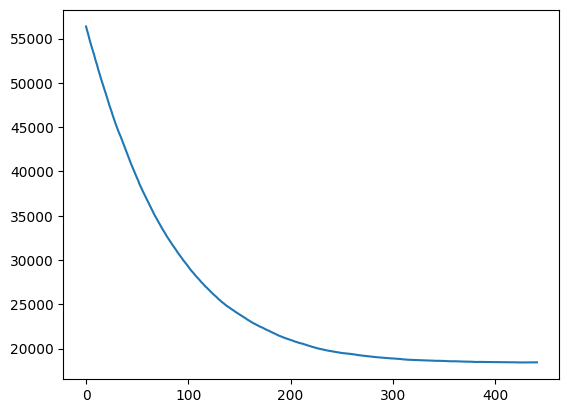

In [ ]:
#Verificando se há Overfiting ou Underfiting
fig, ax = plt.subplots()
results = model_xgb.evals_result()
n_epochs = len(results['validation_0']['mae'])
epochs = range(n_epochs)
ax.plot(epochs, results['validation_0']['mae'])
#ax.set_ylim(15000,25000)

In [ ]:
# Verificando valores previstos
print("Valores reais (y_test):", y_test)
print("Valores previstos (yhat_xgb):", yhat_xgb)

Valores reais (y_test): 529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
435     212000
1369    232000
476     208900
1150    124000
466     167000
Name: sale_price, Length: 482, dtype: int64
Valores previstos (yhat_xgb): [280105.94  142853.95  116355.945 210983.83   98632.086 117181.84
 253977.78  129398.91  515661.88  164438.64  190066.53  157665.38
 231905.33  126020.76  137496.62  140620.56  216135.14  120842.93
 139188.84  181060.11  129374.44  145085.05  112226.73  161994.94
 177320.92  214290.3   172081.22   76218.05  338934.56  114200.48
 148537.    199832.98  139073.75  314838.25  364835.72  194304.34
 270631.7   119935.836 220536.02  318367.4   215771.77  129553.78
 186300.17  301335.2   357328.47  137057.4   127512.22  128890.05
 173084.77  105873.84  384715.97  144043.5   176579.2    82284.76
 247971.02  111489.805 122019.91  237023.53  137465.36   96473.805
 138523.75  129435.336 146130.17  152751.52  203931.73  166280.44
 133104.52

## 7.2. LightGBM

In [88]:
import lightgbm as lgb

# Modelo LightGBM
model_lgbm = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.5,
    colsample_bytree=0.9
)

# Definindo a função de callback para parada antecipada
def early_stopping_monitor():
    best_mae = float("inf")
    early_stopping_counter = 0
    max_early_stopping_rounds = 10
    
    def callback(env):
        nonlocal best_mae, early_stopping_counter
        
        if len(env.evaluation_result_list) < 2:
            return False
        
        current_mae = env.evaluation_result_list[1][2]  # Índice 2 corresponde à métrica MAE
        
        if current_mae < best_mae:
            best_mae = current_mae
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter >= max_early_stopping_rounds:
            print(f'Early stopping triggered. Best MAE: {best_mae}')
            return True
        
        return False
    
    return callback

# Treinamento do modelo com parada antecipada usando callback
model_lgbm.fit(X_train, 
               y_train, 
               eval_set=[(X_train, y_train), (X_val, y_val)], 
               eval_metric='mae', 
               callbacks=[early_stopping_monitor()])

# Previsões
yhat_lgbm = model_lgbm.predict(X_test)

# Avaliação do desempenho
lgbm_result = ml_error('LightGBM Regressor', y_test, yhat_lgbm)
lgbm_result


  File "c:\Users\PâmelaBotelhoMagalhã\.conda\envs\main\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 655, number of used features: 20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 182519.618321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

Model Name           MAE     MAPE          RMSE
0  LightGBM Regressor  18264.978734  0.10075  32715.099712

# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Grid Search

In [ ]:
param_grid = {
    'n_estimators': [1000],
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
}

model_xgb = xgb.XGBRegressor(objective='reg:squarederror',early_stopping_rounds = 10,
eval_metric = 'mae',)

grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)

grid_search.fit(X_train, y_train, eval_set = [(X_val, y_val)])


[0]	validation_0-mae:56366.92768
[1]	validation_0-mae:55960.56951
[2]	validation_0-mae:55541.64377
[3]	validation_0-mae:55085.72867
[4]	validation_0-mae:54653.92860
[5]	validation_0-mae:54257.23234
[6]	validation_0-mae:53880.69321
[7]	validation_0-mae:53500.15030
[8]	validation_0-mae:53133.53057
[9]	validation_0-mae:52675.31893
[10]	validation_0-mae:52308.84438
[11]	validation_0-mae:51942.71415
[12]	validation_0-mae:51495.49690
[13]	validation_0-mae:51103.76461
[14]	validation_0-mae:50724.60410
[15]	validation_0-mae:50345.38332
[16]	validation_0-mae:49975.81622
[17]	validation_0-mae:49630.51350
[18]	validation_0-mae:49237.28251
[19]	validation_0-mae:48907.15253
[20]	validation_0-mae:48558.25547
[21]	validation_0-mae:48184.86547
[22]	validation_0-mae:47806.01180
[23]	validation_0-mae:47417.26519
[24]	validation_0-mae:47096.73254
[25]	validation_0-mae:46762.53260
[26]	validation_0-mae:46374.36175
[27]	validation_0-mae:46032.76848
[28]	validation_0-mae:45727.42212
[29]	validation_0-mae:45

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=10,
                                    enable_categorical=False, eval_metric='mae',
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 0.9],
                         'eta': [0.01, 0.1, 0.3], 'max_depth': [3, 5, 7],
                         'n_estimators': [1000], 'subsample': [0.5, 0.7, 0.9]},
             scoring='neg_mean_absolute_percentage_error')

In [ ]:
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

Melhores parâmetros encontrados: {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}


In [ ]:
best_score = grid_search.best_score_
print("Melhor score encontrado:", best_score)

Melhor score encontrado: -0.10851362044947177


 ## 8.2. Final Model

In [67]:
param_tuned = {
    'n_estimators': 1000,
    'eta': 0.01,
    'max_depth': 5,
    'subsample': 0.5,
    'colsample_bytree': 0.9,
        }

In [68]:
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    eval_metric='mae',
                                    early_stopping_rounds = 10,
                                    colsample_bytree=param_tuned['colsample_bytree']).fit(X_train, y_train, eval_set=[(X_val, y_val)])


yhat_xgb_tuned = model_xgb_tuned.predict(X_test)


xgb_result_tuned = ml_error('XGBoost Regressor (Tuned)', y_test, yhat_xgb_tuned)
xgb_result_tuned

[0]	validation_0-mae:56361.94268
[1]	validation_0-mae:55916.76838
[2]	validation_0-mae:55456.92574
[3]	validation_0-mae:55022.37727
[4]	validation_0-mae:54610.54717
[5]	validation_0-mae:54206.09452
[6]	validation_0-mae:53794.87616
[7]	validation_0-mae:53402.67023
[8]	validation_0-mae:52984.55916
[9]	validation_0-mae:52535.67449
[10]	validation_0-mae:52207.71701
[11]	validation_0-mae:51843.92966
[12]	validation_0-mae:51431.37752
[13]	validation_0-mae:51019.66360
[14]	validation_0-mae:50647.56647
[15]	validation_0-mae:50265.76074
[16]	validation_0-mae:49936.26084
[17]	validation_0-mae:49563.55781
[18]	validation_0-mae:49186.34123
[19]	validation_0-mae:48829.29373
[20]	validation_0-mae:48492.80249
[21]	validation_0-mae:48142.36682
[22]	validation_0-mae:47758.00000
[23]	validation_0-mae:47379.85149
[24]	validation_0-mae:47000.47813
[25]	validation_0-mae:46675.75039
[26]	validation_0-mae:46300.12171
[27]	validation_0-mae:45967.95574
[28]	validation_0-mae:45673.71725
[29]	validation_0-mae:45

Model Name           MAE      MAPE          RMSE
0  XGBoost Regressor (Tuned)  17486.662669  0.097704  31564.275006

In [74]:
# Fazer previsões no conjunto de teste
yhat_xgb_tuned = model_xgb_tuned.predict(X_test)

# Crie o DataFrame para o arquivo de submissão
submission = pd.DataFrame({
    'id': X_test['id'],  
    'SalePrice': yhat_xgb_tuned  
})

# Salve o arquivo de submissão
submission.to_csv('submission.csv', index=False)

print("Arquivo de submissão criado com sucesso.")

Arquivo de submissão criado com sucesso.
